# Assignment 3

### Task 1 - Simulation

Let the process ${X_t}$ be an AR(2) given by:

$$X_t + ϕ_1 X_{t−1} + ϕ_2 X_{t−2} = ϵ_t$$

where ${ϵ_t}$ is a white noise process with $σ_ε = 1$.

##### 1.1 Realisations

Iteratively simulate the process:

$$X_t = - ϕ_1 X_{t−1} - ϕ_2 X_{t−2} + ϵ_t$$

for the initial values set $X_{t−1} = 1, X_{t−2} = 1$

In [163]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

phi1, phi2, n = -0.6, 0.5, 200
real = [1, 1]
for _ in range(n):
    real.append(phi1*real[-1]+phi2*real[-2]+np.random.randn())

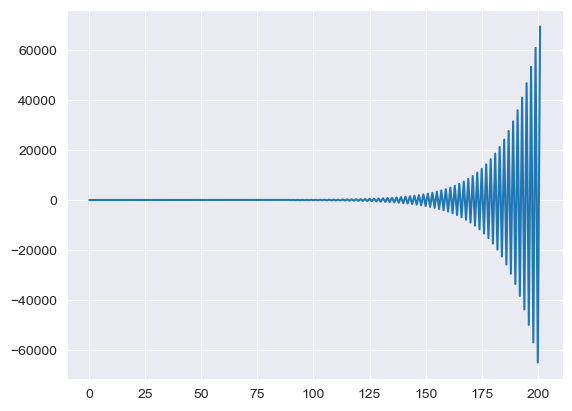

In [161]:
plt.plot(real)

Doesn't look dynamically stationary. Out of curiosity, test for it:

In [162]:
z1 = (-phi1 + ((phi1**2)-4*phi2)**0.5)/2
z2 = (-phi1 - ((phi1**2)-4*phi2)**0.5)/2

print(f"|z1| = {abs(z1):.4f} and |z2| = {abs(z2):.4f} must lie within the unit circle; |z| < 1")

|z1| = 0.7071 and |z2| = 0.7071 must lie within the unit circle; |z| < 1


They do lie within the unit circle, so they are technically stable?!

##### 1.3 Simulations and stationarity

**Weak Stationarity:**
- the process variance and mean stay approximately the same over time
- trend models are non-weak-stationary, because the mean changes
- models can be made weakly stationary by differencing or de-trending (applying a trend model first and then work on the residuals)

**Dynamic Stationarity:**
There are TWO different formulations: both rely on roots of the characteristic equation (a polynomial / a Z transform)

1. inverse formulation need all roots (Nullstellen) of z to be *within* the unit circle; for AR(p):
    $$X_t + \sum_{i=1}^p \phi_i B^i X_t = \varepsilon_t$$
    substitute $B=z^{-1}$, multiply by $z^p$ and factor out $X_t$
    $$\Rightarrow X_t(z^p + \phi_1 z^{p-1} + ... + \phi_p) = 0$$

2. regular formulation needs all roots of z to be *outside* the unit circle

In [132]:
phi1, phi2 = -0.6, -0.3

z1 = (-phi1 + ((phi1**2)-4*phi2)**0.5)/2
z2 = (-phi1 - ((phi1**2)-4*phi2)**0.5)/2

# inverse root formulation |z|<1 must be inside the unit circle
print(z1, z2)

0.9244997998398399 -0.32449979983983984


### Task 2 - Predicting Power with SAR(2)

### Task 3 - Box heating with ARX

The final part is about identifying a suitable ARX model for predicting the hourly heating of a test box (a small building). The box has a window in the south facing wall.

In an experiment times series were recorded of the variables:
- $P_h$ (Ph in data) the heat from electrical heaters (W).
- $T_{\text{delta}}$ (Tdelta in data) the difference between the internal and external temperature (◦C)
- $G_v$ (Gv in data) the vertical solar radiation onto the box side with a window (W/m2)

The data consists of average hourly values – in total 231 hours. It’s available in the ```box_data_60min.csv``` file.

In the experiment the internal air temperature was kept constant with a thermostatic control of the heating – hence the heating change depending on the weather conditions.

The objective is to find a suitable model, which makes good predictions of the heating.

Lags have been generated and included in the data with a naming syntax such that, e.g.: Ph.l1 is the heating lagged one step, Ph.l2 is heating lagged two steps and so fourth.

##### 3.1

In [164]:
import pandas as pd

df = pd.read_csv("./../data/box_data_60min.csv")
df.tdate = pd.to_datetime(df.tdate)
df.set_index(df.tdate, inplace=True)
# thour starts at 19!?! --> re-index
df['thour'] = range(1,len(df)+1)

/var/folders/5b/3rjqcwwn5s93khgglxljhv140000gn/T/ipykernel_71054/3940847846.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(df.tdate.apply(lambda x: x.hour))


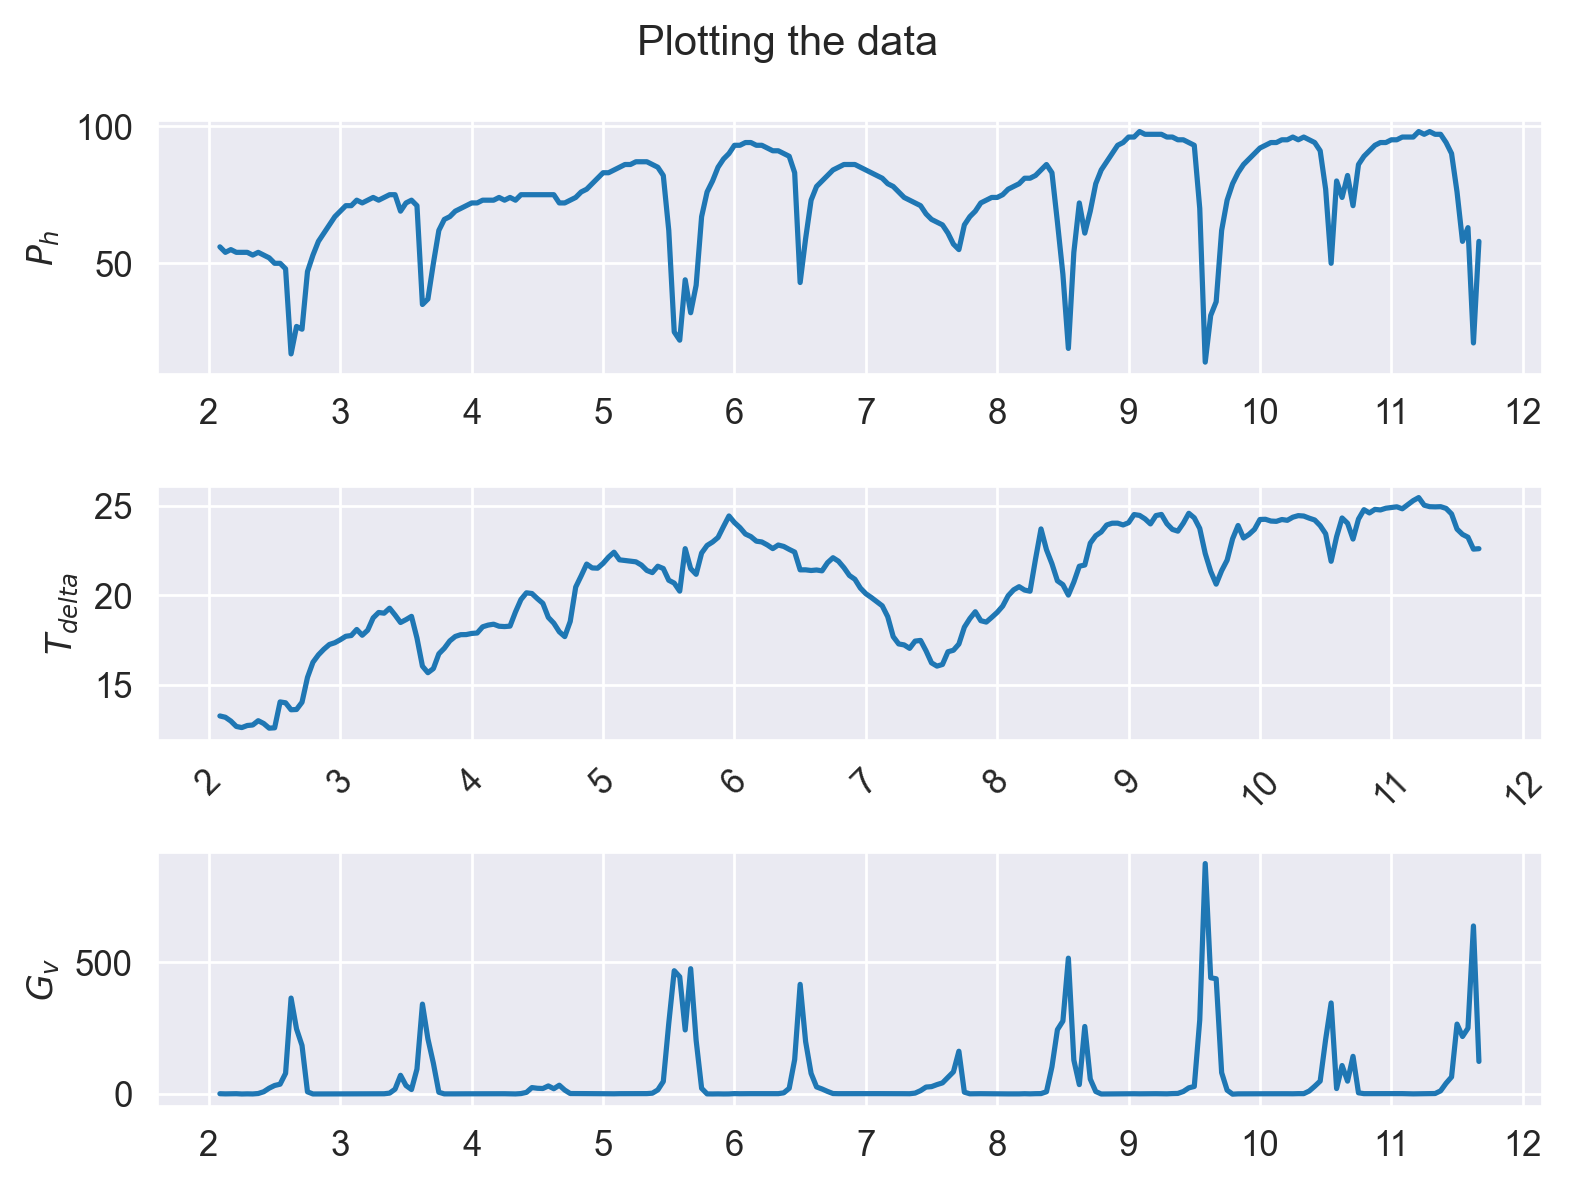

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

fig = plt.figure(dpi=250)
fig.suptitle("Plotting the data")
ax3 = plt.subplot(313)
ax1 = plt.subplot(311, sharex=ax3)
ax2 = plt.subplot(312, sharex=ax3)

ax1.plot(df.Ph)
ax1.set_xticklabels([])
ax1.set_ylabel("$P_h$")

ax2.plot(df.Tdelta)
ax2.set_ylabel("$T_{delta}$")

ax3.plot(df.Gv)
ax3.set_ylabel("$G_v$")
ax3.set_xticklabels(df.tdate.apply(lambda x: x.hour))

plt.xticks(rotation=45)
plt.tight_layout()

*Comment:*

Clearly there is an inverse relation between $P_h$ and $G_v$, which is just by construction. The peaks of $G_v$ and the drops in $G_v$ conincide, however, not in value magnitude but just in location and relative severity. 

Additionally, the drops are also present in $T_d$, whilst significantly weaker than in $P_h$.

Tracing along all the buckling peaks of $P_h$ and the peaks of $T_d$, one can observe a notion of a correlated moving trendline.

##### 3.2

In [165]:
cutoff = "2013-02-06 00:00"
df_train = df[df.tdate<=cutoff]

##### 3.3 investigate relationships

In [5]:
import numpy as np

# cross correlation - non-commutative but symmetric; time-lagged correlation; convolution
pg = np.correlate(df_train.Ph, df_train.Gv)
pt = np.correlate(df_train.Ph, df_train.Tdelta, mode='full')
gt = np.correlate(df_train.Gv, df_train.Tdelta, mode='same')

# correlation
corr = df_train[['Ph', 'Gv', 'Tdelta']].corr()

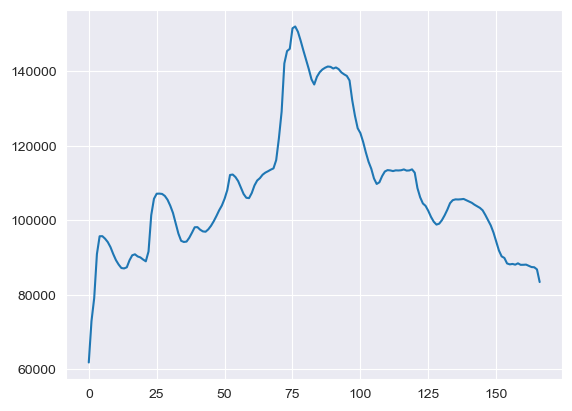

In [6]:
plt.plot(gt)

<Axes: >

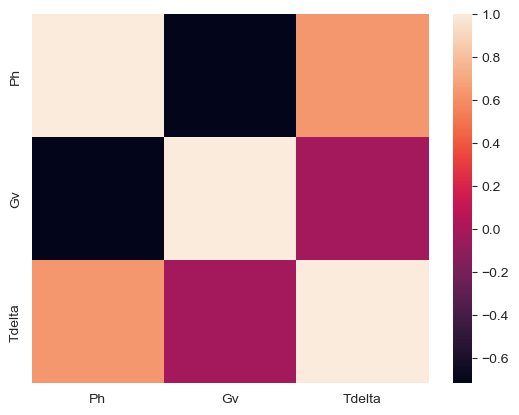

In [7]:
sns.heatmap(corr)

In [ ]:
# scatter plots
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
plt.scatter(scaler.fit_transform(df_train.Ph.to_numpy().reshape(-1,1)), scaler.fit_transform(df_train.Gv.to_numpy().reshape(-1,1)))
plt.scatter(scaler.fit_transform(df_train.Tdelta.to_numpy().reshape(-1,1)), scaler.fit_transform(df_train.Gv.to_numpy().reshape(-1,1)))
plt.scatter(scaler.fit_transform(df_train.Tdelta.to_numpy().reshape(-1,1)), scaler.fit_transform(df_train.Ph.to_numpy().reshape(-1,1)))

### 3.4 Impulse Response Function

**Question:** Which series should be the impulse and which should model the response?
- T with G as impulse?
- T with G and P as impulse?
- P with T and G as impulse? <-- probably this

Estimating the impulse response, usually involves knowing the parameters for a model. The goal is to see how a unit-impulse in the beginning propagates recursively throughout the model. 

*model/ recursion for impulse response from slides*

For a model with lag $k$ up to $10$, we need at least $10$ coefficients (for each time-series) for the model, since the signal shall be dependent on $10$ past observations, this makes $20$ total parameters for a model with ONE exogenous variable or $30$ with 2 exogenous variables. Assume a model, where $\{T_t\}$ represents the series $T_{\text{delta}}$, $\{G_t\}$ is the series $G_v$ and $\{P_t\}$ is the series $P_h$ for $t \in \{1, ... , 167\}$ in the training dataset. 

$$\text{ARX}(k=10) = c + \sum_{i=0}^k \phi_{i} B^{i} P_{t} + \sum_{i=0}^{k} \omega_i B^i T_t + \varepsilon_t$$

for $T_{\text{delta}}$ as exogenous or

$$\text{ARX}(k=10) = c + \sum_{i=0}^k \phi_{i} B^{i} P_{t} + \sum_{i=0}^{k} \beta_i B^i G_t + \varepsilon_t$$

for $G_v$ as exogenous or 

$$\text{ARX}(k=10) = c + \sum_{i=0}^k \phi_{i} B^{i} P_{t} + \sum_{i=0}^{k} \omega_i B^i T_t + \sum_{i=0}^{k} \beta_i B^i G_t + \varepsilon_t$$

for both as exogenous, given parameters/coefficients $\phi_i, \beta_i, \omega_i \in \mathbb{R}$.

For now, assuming only $T_{\text{delta}}$ as the exogenous variable and $P_h$ as the indogenous, for the recursive impulse response of an ARX model, this means:

$$\begin{align*}
\text{IR}(0) &= 1 \\
\text{IR}(1) &= \text{IR}(0) \phi_1 + \text{IR}(0) \omega_1 \\
&\;\;\vdots \\
\text{IR}(k=10) &= \sum_{j=0}^{k-1} \text{IR}(j) \phi_{j+1} + \sum_{j=0}^{k-1} \text{IR}(j) \omega_{j+1} \\
\end{align*}$$

This would be a full-scale AR-ARX model, since it also takes into account past obervations of the exogenous variable. In practice, it is often just the most recent observation of the exogenous variable that is taken into account, hence:

$$\begin{align*}
&& \text{ARX}(k) &= c + \sum_{i=0}^k \phi_{i} B^{i} P_{t} +  \omega_1 T_t + \beta_1 G_t + \varepsilon_t \\
\Leftrightarrow && -P_t &= c +  \sum_{i=1}^k \phi_{i} B^{i} P_{t} +  \omega_1 T_t + \beta_1 G_t + \varepsilon_t \\
\Rightarrow && \text{IR}(n, k) &= \sum_{j=0}^{n-1} \text{IR}(j+k) \phi_{j+1} + \omega_1 \mathbb{I}_{k=0} + \beta_1 \mathbb{I}_{k=0}
\end{align*}$$

**CORRECT THIS RECURSIVE EQUATION** - $\phi_j$ can only cycle through order n, but lag k can go through further recursion of IR

for lag $k$ and the ARX model of order $n$.

Having such a complex model, there is no way to "estimate" it with sufficient accuracy. One could potentially read off a maybe the first two $\phi_1, \phi_2$ parameters of the AR part of the model, conclude that the following coefficients are $<1$ and maybe even find an argument for an alternating sign of he coefficients, based on the ACF and PACF plots. However, none of this will yield a usable result. Thus, we need to fit a model to the data. 

We will use the the ```AutoReg```class from ```statsmodels.tsa.ar_model``` which allows to provide an exogenous variable and has built in parameter estimation (via OLS and conditional MLE).

In [536]:
from statsmodels.tsa.ar_model import AutoReg

# Fit the ARMAX model
model = AutoReg(df_train.Ph, lags=10, exog=df_train.Tdelta)
results = model.fit()
results.params.values.round(4)

array([ 0.8213,  0.9246, -0.2851,  0.1119, -0.0062, -0.0793, -0.0014,
        0.0053, -0.0331,  0.0281, -0.0582,  1.3917])

The exogenous variable $T_t$ is the last coefficient in the parameters.

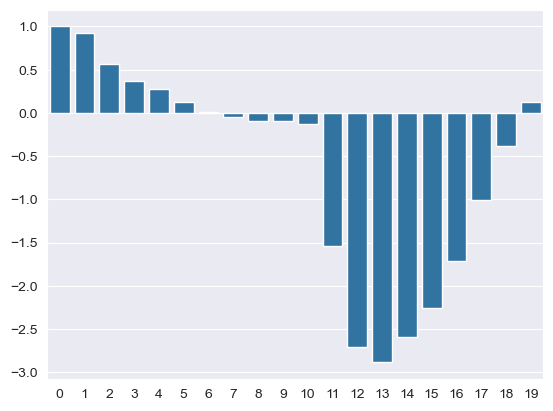

In [69]:
from statsmodels.tsa.arima_process import arma_impulse_response

ar = np.r_[1.0, -results.params.values[1:-1], results.params.values[-1]]
ir = arma_impulse_response(ar=ar, ma=[1.0], leads=20)
sns.barplot(ir);

This looks odd. Options:

- **Manual parameter estimation via OLS**
- manual implementation of impulse response

given the model:

$$ P_t = c - \sum_{i=1}^{10} \phi_i P_{t-i} + \omega_1 T_t$$

and the impulse response (IR):

$$\text{IR}(k=10) = \sum_{j=0}^{k-1} \text{IR}(j) \phi_{j+1} + \mathbb{I}_{k=0} \omega_1$$

Or shorter sum notation:

$$\mathrm{\text{IRF}}(k) = \sum_{i = 1}^{k}\sum_{j = 0}^{\min(i,p)}\left\lbrack \phi_{j}\mathrm{\text{IRF}}(i - j - 1)\mathbb{I}_{i - j - 1 \geq 0} \right\rbrack$$


In [ ]:
# manual impulse response
ir = [results.params.values[1]*0 + results.params.values[-1]*1] # initial impulse from

Going back to the ```statsmodels``` estimated parameters and model fitting summary: 

Interesting to see here, is the P-value significance from the OLS parameter estimation. Based on that, only the first two AR parameters and the exogenous parameter are statistically significant (on level $\alpha=0.05$).

Thus we could technically simplify the model a lot, by only taking the first two $\phi_1, \phi_2$ and $\omega_1$.

Hence the model would become an ARX(2) model:

$$P_t = -P_{t-1} \phi_1 - P_{t-2} \phi_2 + \omega_1 T_t$$

with $\phi_1 \approx 0.9246, \phi_2 \approx -0.2851, \omega_1 \approx 1.3917$.

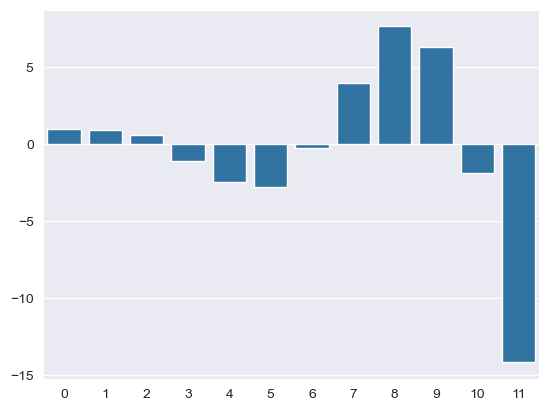

In [62]:
ir = arma_impulse_response(ar=[1, -0.9246, 0.2851, 1.3917], ma=[1], leads=12)
sns.barplot(ir);

One can see that it is somewhat similar up to lag $10$, then the scale becomes drastically different, because there are no higher-order terms/coefficients that scale down.

However, this is a known phenomenon. As soon as the lags exceed the number of coefficients, the amplitudes of the impulse respond become extreme.

##### 3.4.1 Impulse Response Manually

1. ARX(10) for P_t and unit impulse from T_d
2. ARX(10) for P_t and unit impulse from G_v

##### 3.4.1.1 - ARX IR: $P_t \leftarrow T_{\text{delta}}$

**Manual Parameter Estimation:**

For an ARX(10) model, with $T_{\text{delta}}$ as our exogenous variable:

$$ P_t = c - \sum_{i=1}^{10} \phi_i P_{t-i} + \omega_1 T_t$$

we can use OLS to estimate parameters, with the design matrix:

$$ X = [1, P_{t-1}, P_{t-2}, P_{t-3}, ..., P_{t-10}, T_t]$$

as column-vectors. As we want an OLS estimate, we cannot pad the values that become undefined when lagging the time-series, thus we need to fully shift all our series ($P_t = (p_0, p_1, p_2, ...)$). 

$$ \Rightarrow X =
\begin{bmatrix}
1 & p_9 & p_8 & p_7 & \dots & p_0 & t_{10} \\
1 & p_{10} & p_9 & p_8 & \dots & p_1 & t_{11} \\
1 & p_{11} & p_{10} & p_9 & \dots & p_2 & t_{12} \\
\vdots & \vdots & \vdots & \vdots & & \vdots & \vdots\\
\end{bmatrix}$$

This means, for any predictions, we need to accept a burn in period equal the the order/lag of the model $k=10$.

Now the parameters of the model become $\Theta = [c, - \phi_1 ..., - \phi_{10}, \omega_1]^T \in \mathbb{R}^{k+2}$ and the target vector $Y = [p_{10}, p_{11}, ...] = P_{t-k}$. The OLS model is thus:

$$\begin{align*}
&& P_{t-k} &= X \cdot \Theta + \varepsilon_t = Y\\
\Leftrightarrow && \hat{\Theta} &= (X^T X)^{-1} X^T Y \\
\end{align*}$$

In [618]:
import numpy as np

k = 10
Y = df_train.Ph.to_numpy().reshape(-1,1) # P_h
X = np.ones((Y.shape[0]-k, k+2))
for col in range(1,k+1):
    X[:, col] = Y[k-col:len(Y)-col].reshape(-1,)
X[:,-1] = df_train.Tdelta.to_numpy().reshape(-1,)[k:]
Y = Y[k:]

Theta = np.linalg.inv(X.T@X)@X.T@Y
Theta[1:-1]*=(-1) # sign reversion from model
print(Theta.round(4).flatten())

[ 0.8213 -0.9246  0.2851 -0.1119  0.0062  0.0793  0.0014 -0.0053  0.0331
 -0.0281  0.0582  1.3917]


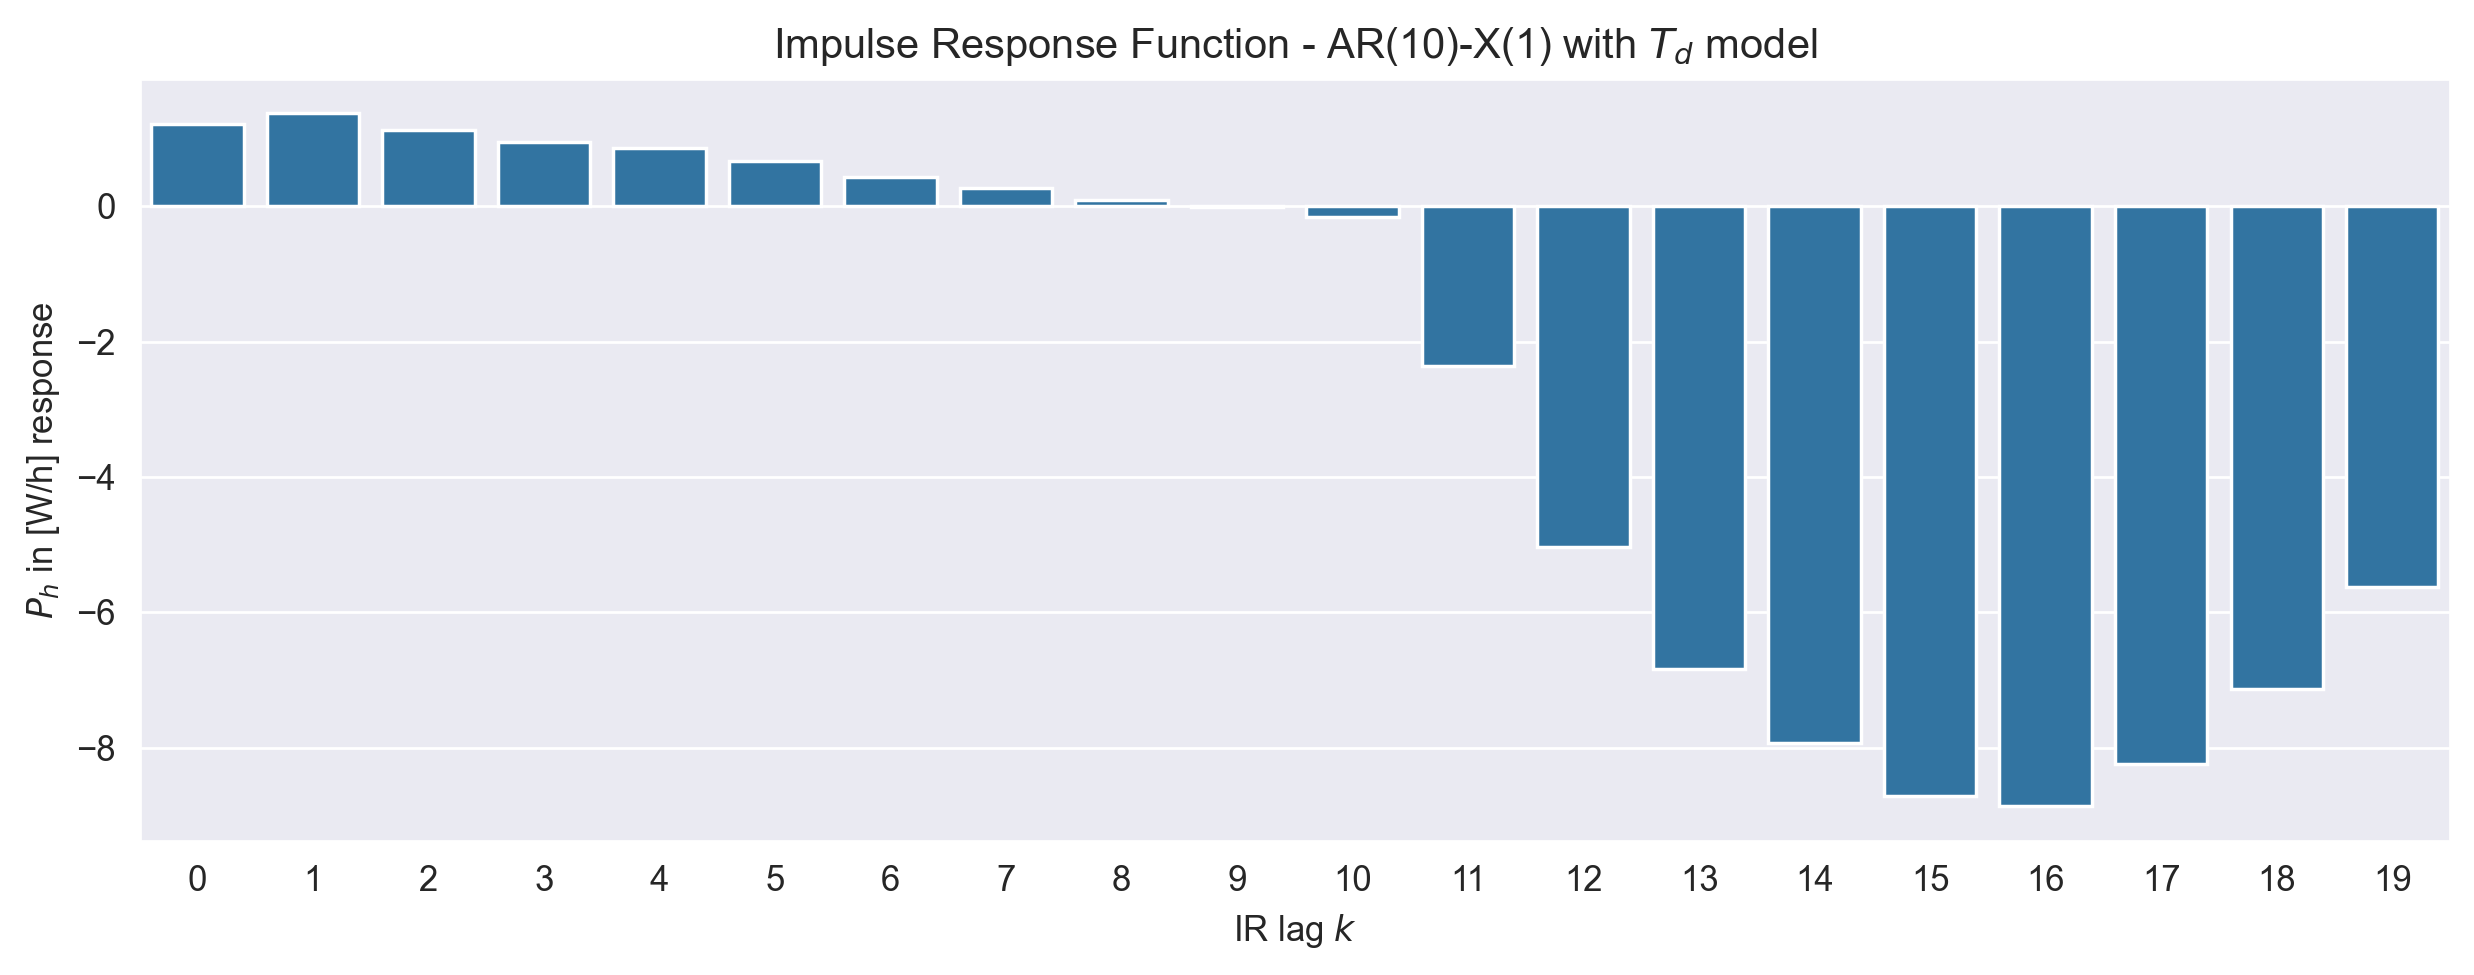

In [620]:
import matplotlib.pyplot as plt
import seaborn as sns

ir = arma_impulse_response(ar=Theta.flatten(), ma=[1.0], leads=20)

def plot_ir(ir:np.ndarray, model_name:str):
    plt.figure(figsize=(10,4), dpi=250)
    plt.title(f"Impulse Response Function - {model_name} model")
    sns.barplot(ir)
    plt.xlabel("IR lag $k$")
    plt.ylabel("$P_h$ in [W/h] response")
    plt.tight_layout()

plot_ir(ir, "AR(10)-X(1) with $T_d$")

Actually, this fits very well with the first version from above. The manually estimated coefficients

$$\Theta = [ 0.8213, -0.9246,  0.2851, -0.1119,  0.0062,  0.0793,  0.0014, -0.0053,  0.0331, -0.0281,  0.0582,  1.3917]$$

match the ones from the ```statsmodels.tsa.ar_models.AutoReg``` class implementation.

##### 3.4.2 - ARX IR: $P_t \leftarrow G_t$

For an ARX(10) model, with $G_t$ as our exogenous variable:

$$ P_t = c - \sum_{i=1}^{10} \phi_i P_{t-i} + \beta_1 G_t$$

we can use OLS to estimate parameters, with the design matrix:

$$ X = [1, P_{t-1}, P_{t-2}, P_{t-3}, ..., P_{t-10}, G_t]$$

as column-vectors and parameter vector $\Theta = [c, - \phi_1 ..., - \phi_{10}, \omega_1]^T \in \mathbb{R}^{k+2}$.

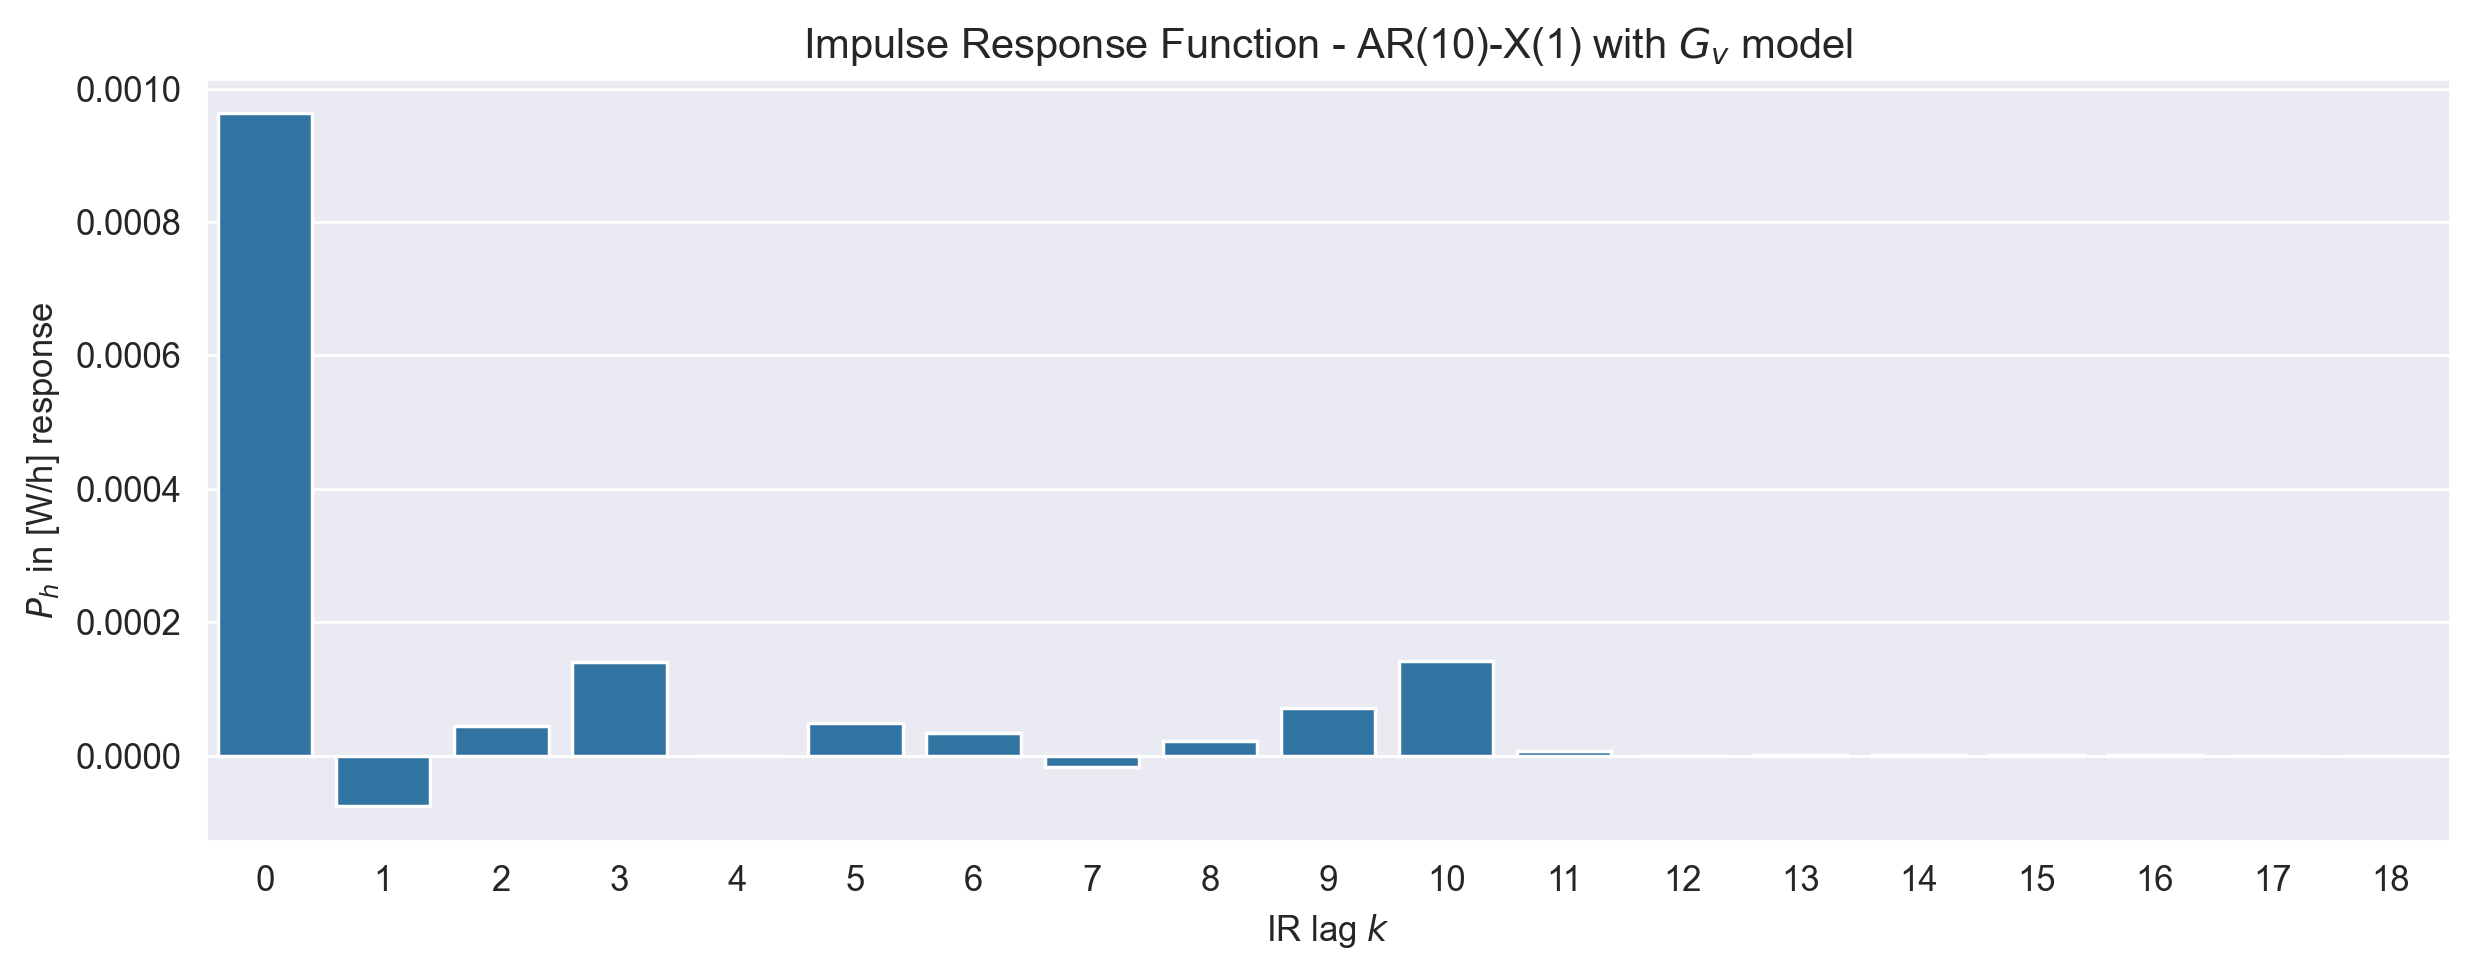

In [621]:
X[:, -1] = df_train.Gv.to_numpy().reshape(-1,)[k:]
Theta = np.linalg.inv(X.T@X)@X.T@Y
Theta[1:-1]*=(-1) # sign reversion from model

ir = arma_impulse_response(ar=Theta.flatten(), ma=[1.0], leads=20)
plot_ir(ir[1:], "AR(10)-X(1) with $G_v$") # first value is extremely large

In [623]:
print(Theta.round(4).flatten())

[ 2.44688e+01 -5.76400e-01  5.89000e-02 -2.87000e-02 -8.28000e-02
  4.50000e-03 -3.00000e-02 -1.87000e-02  1.13000e-02 -1.37000e-02
 -4.22000e-02 -8.28000e-02]


In [624]:
model = AutoReg(endog=df_train['Ph'].to_numpy(), lags=10, exog=df_train['Gv'].to_numpy())
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  167
Model:                  AutoReg-X(10)   Log Likelihood                -466.796
Method:               Conditional MLE   S.D. of innovations              4.732
Date:                Sun, 20 Apr 2025   AIC                            959.592
Time:                        16:58:03   BIC                            999.323
Sample:                            10   HQIC                           975.728
                                  167                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4688      2.609      9.380      0.000      19.356      29.582
y.L1           0.5764      0.053     10.781      0.000       0.472       0.681
y.L2          -0.0589      0.069     -0.860      0.390      -0.193       0.075
y.L3           0.0287      0.069      0.417      0.676      -0.106       0.164
y.L4           0.0828      0.069      1.200      0.230      -0.052       0.218
y.L5          -0.0045      0.069     -0.066      0.947      -0.140       0.131
y.L6           0.0300      0.069      0.437      0.662      -0.105       0.165
y.L7           0.0187      0.069      0.272      0.785      -0.116       0.154
y.L8          -0.0113      0.069     -0.164      0.870      -0.146       0.123
y.L9           0.0137      0.068      0.203      0.839      -0.119       0.146
y.L10          0.0422      0.047      0.904      0.366      -0.049       0.134
x1            -0.0828      0.005    -17.688      0.000      -0.092      -0.074
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.1282           -0.0000j            1.1282           -0.0000
AR.2             1.1218           -0.7385j            1.3431           -0.0927
AR.3             1.1218           +0.7385j            1.3431            0.0927
AR.4             0.4925           -1.2387j            1.3330           -0.1898
AR.5             0.4925           +1.2387j            1.3330            0.1898
AR.6            -0.3457           -1.3284j            1.3726           -0.2905
AR.7            -0.3457           +1.3284j            1.3726            0.2905
AR.8            -1.2448           -0.8763j            1.5223           -0.4024
AR.9            -1.2448           +0.8763j            1.5223            0.4024
AR.10           -1.4998           -0.0000j            1.4998           -0.5000
------------------------------------------------------------------------------
"""

The estimates match. The coefficients are very small, so the impulse response is very weak accordingly, except for the first value, where the unit impulse is induced into the system.

Now for an AR(10)-X(1,1) model with both exogenous variables:

$$ P_t = c - \sum_{i=1}^{10} \phi_i P_{t-i} + \omega_1 T_t + \beta_1 G_t + \varepsilon_t$$

In [650]:
import numpy as np

p, k, n_exog = 10, 20, 2                    # p order of AR; k lag for IR
Y = df_train.Ph.to_numpy().reshape(-1,1)    # P_h
X = np.ones((Y.shape[0]-p, p+n_exog+1))
for col in range(1,p+1):
    X[:, col] = Y[p-col:len(Y)-col].reshape(-1,)
X[:,-n_exog] = df_train.Tdelta.to_numpy().reshape(-1,)[p:]
X[:,-n_exog+1] = df_train.Gv.to_numpy().reshape(-1,)[p:]
Y = Y[p:]

Theta = np.linalg.inv(X.T@X)@X.T@Y
#Theta[1:-n_exog] *= (-1)
print(Theta.round(4).tolist())

[[3.3073], [0.3294], [0.0069], [-0.0176], [0.086], [0.0124], [0.0308], [0.0171], [-0.0191], [0.0081], [-0.0022], [2.0537], [-0.0925]]


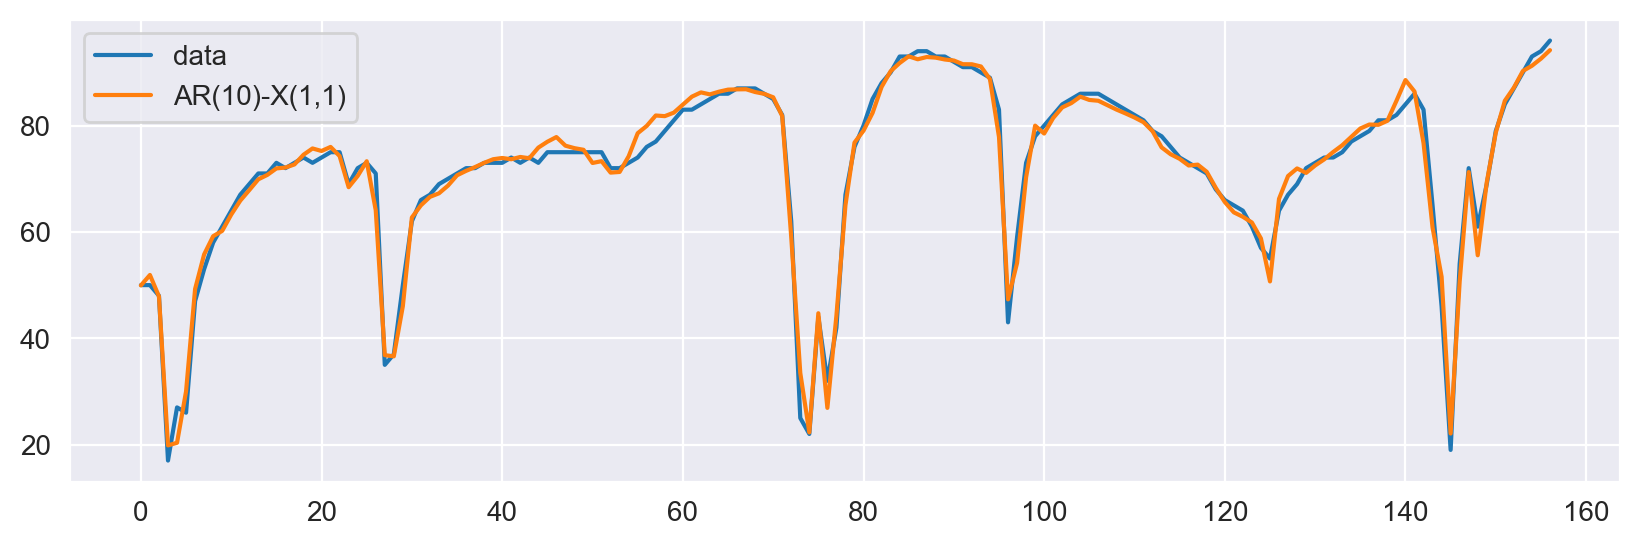

In [627]:
# reality check
plt.figure(figsize=(10,3), dpi=200)
plt.plot(Y, label='data')
plt.plot(X@Theta, label='AR(10)-X(1,1)')
plt.legend()

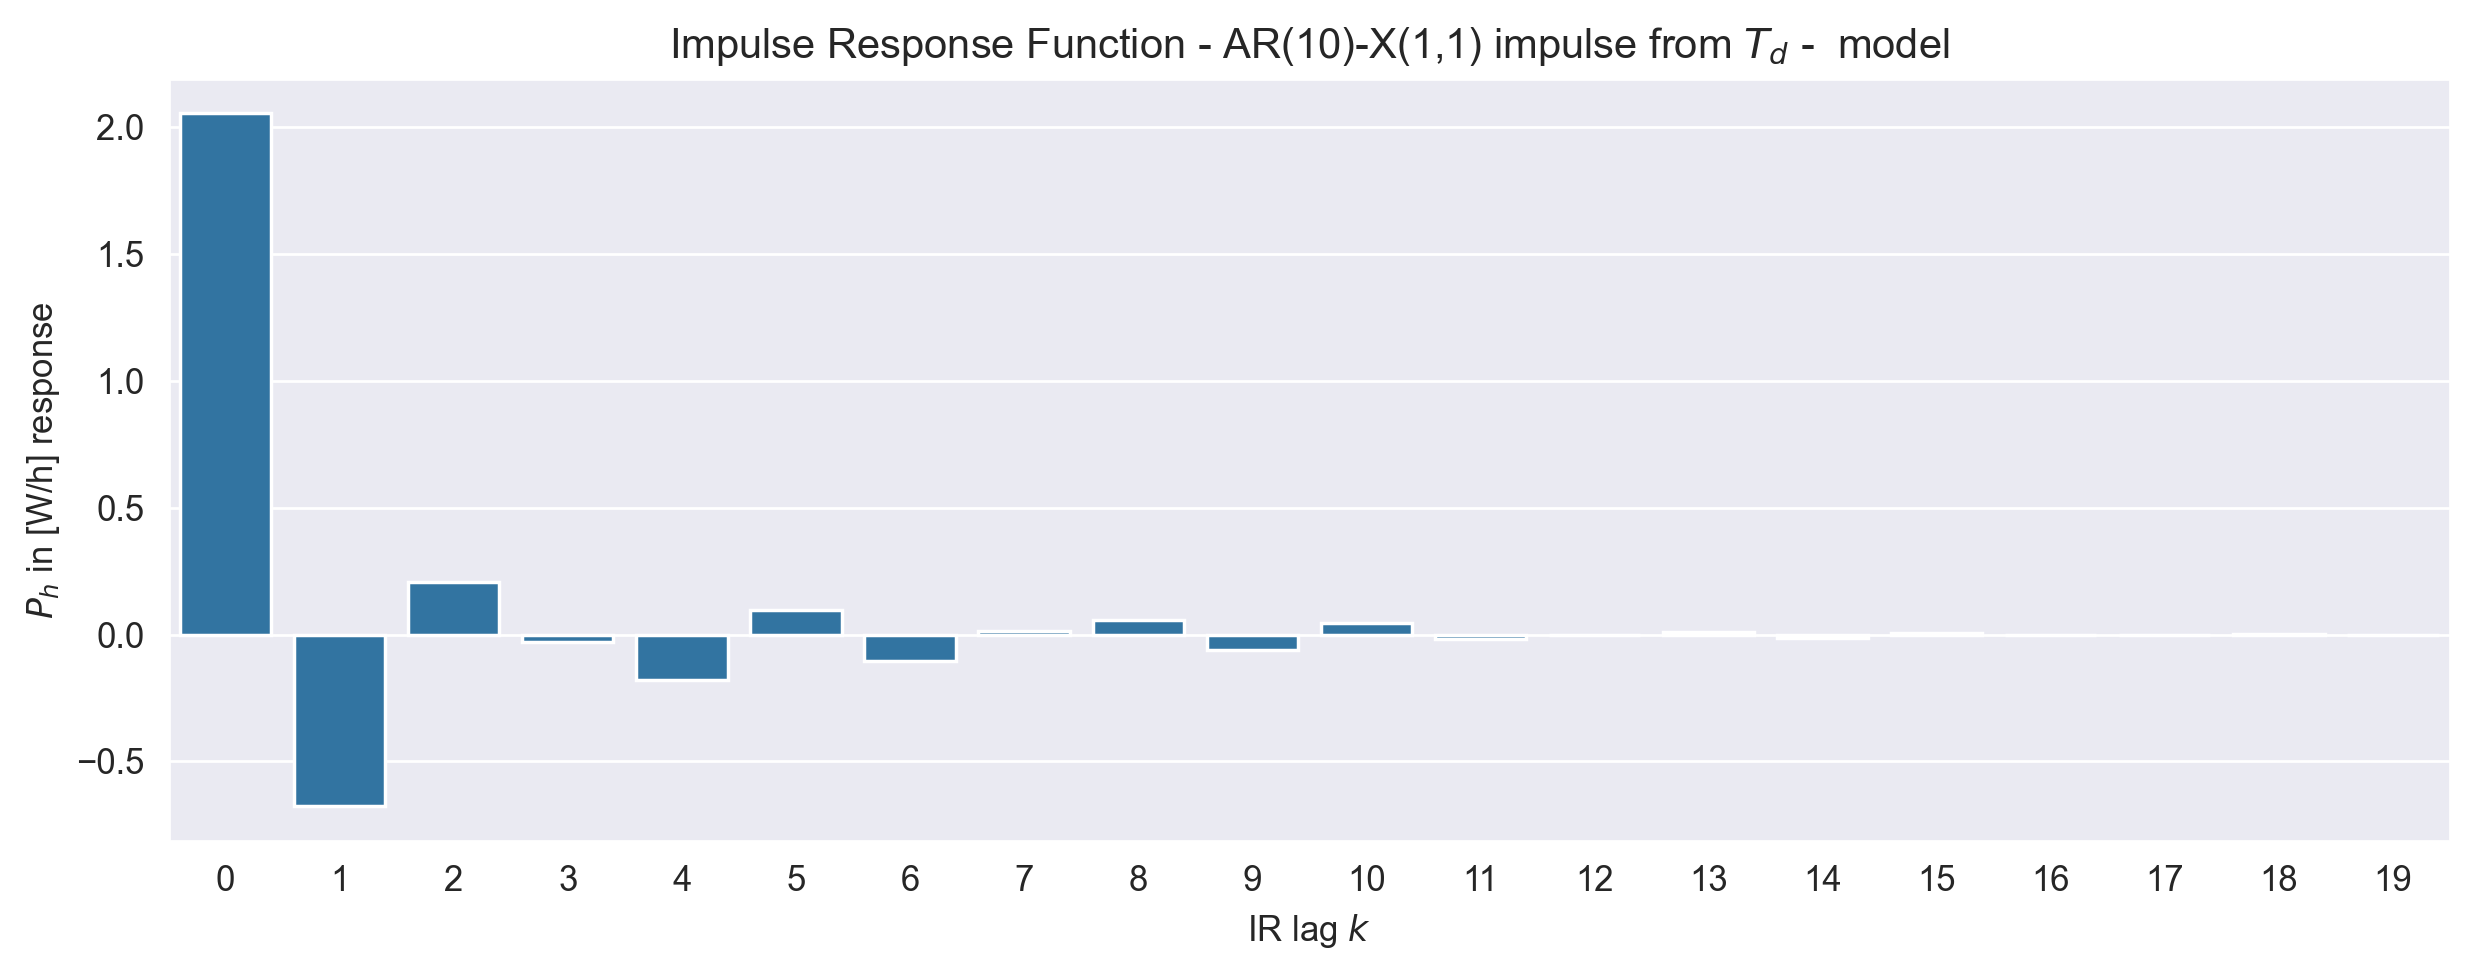

In [628]:
from statsmodels.tsa.arima_process import arma_impulse_response
import seaborn as sns

# aparently the statsmodels ir takes the initial ir(0) as ma argument
ir0 = Theta[-2]             # impulse from T_d
ir = arma_impulse_response(ar=np.r_[1, Theta.flatten()[1:-n_exog]], 
                           ma=[float(ir0)], leads=20)

plot_ir(ir, "AR(10)-X(1,1) impulse from $T_d$ - ")

Now own implementation of impulse response; after the statsmodels one behaved weirdly and not according to the formula.

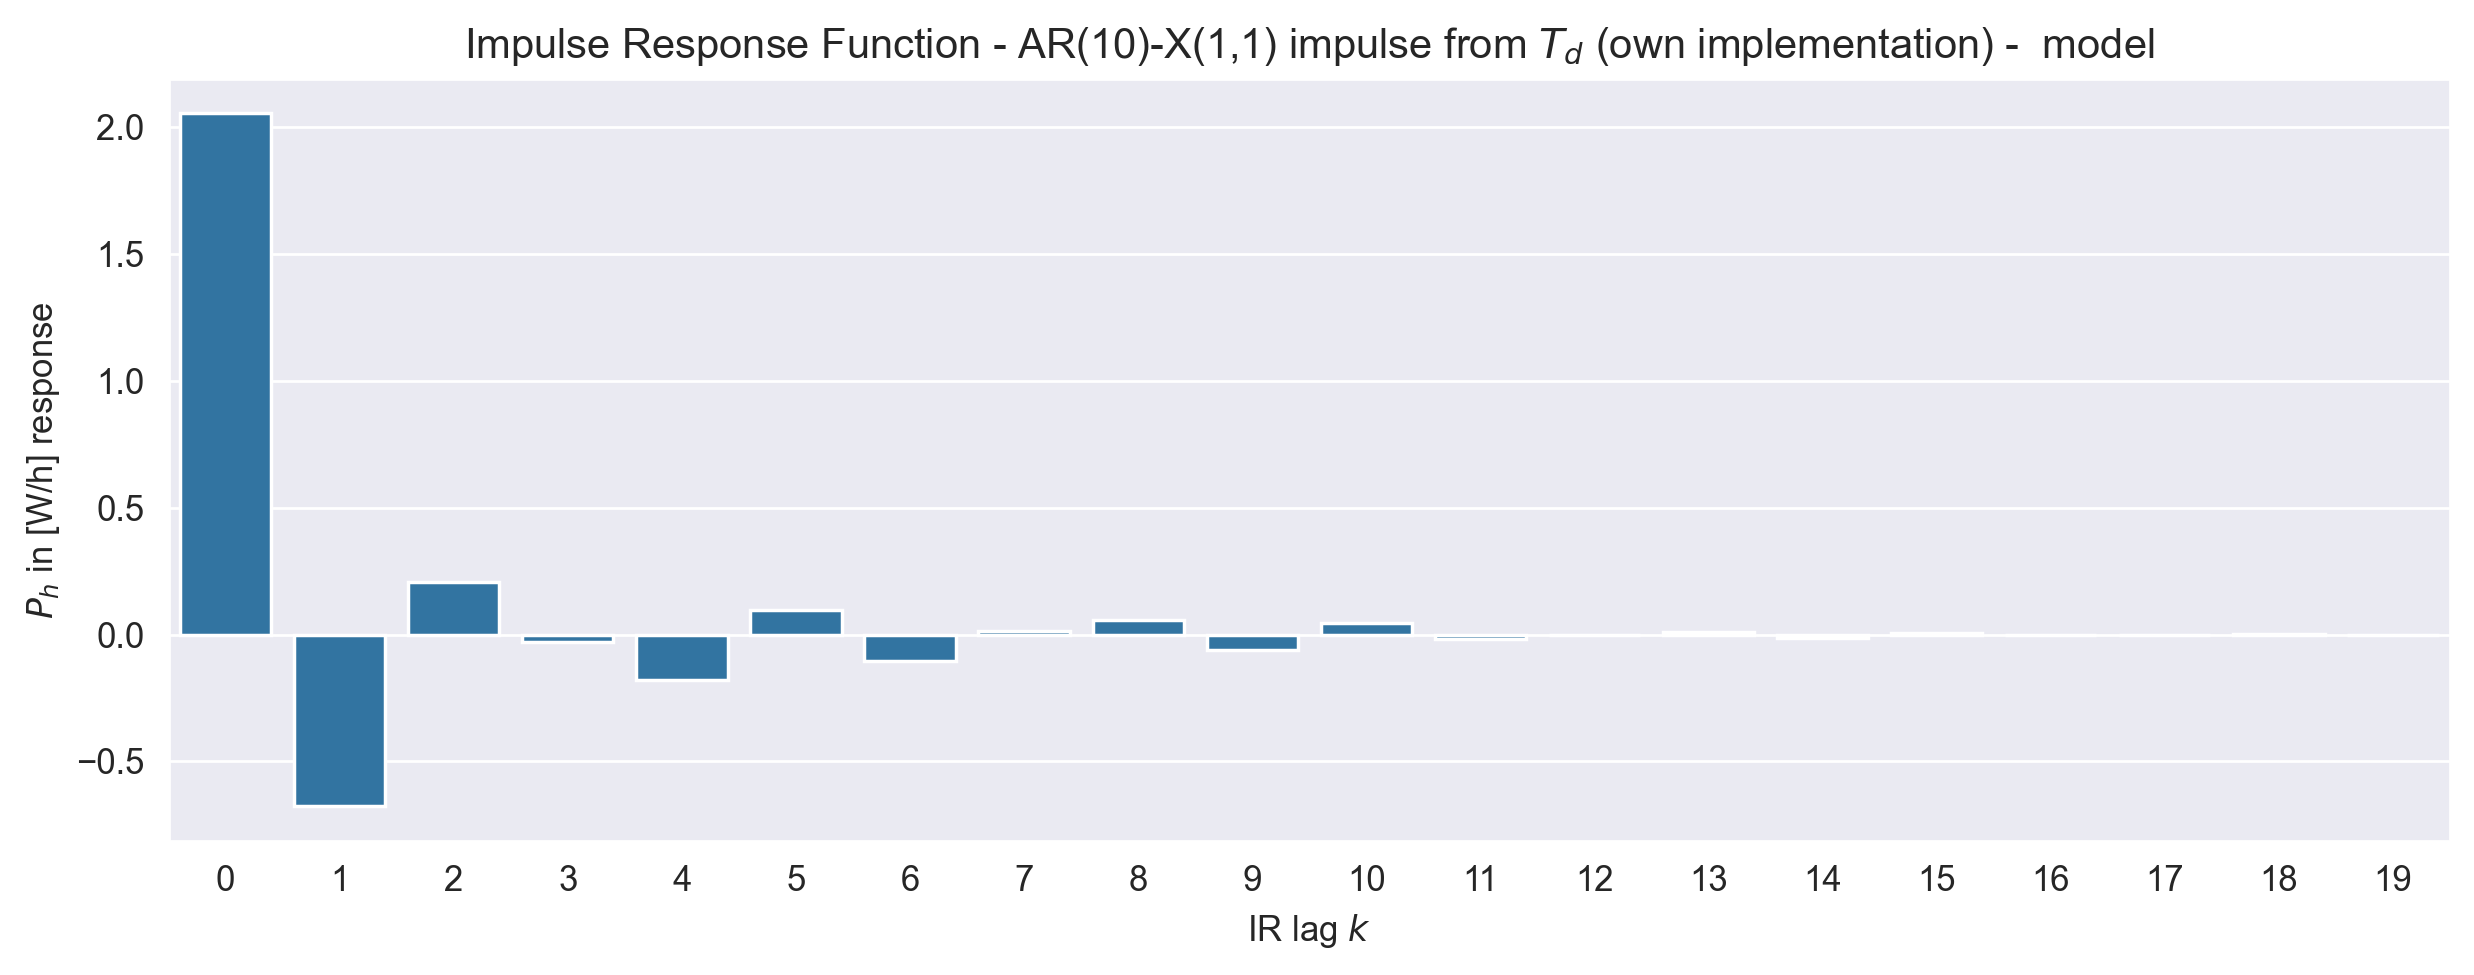

In [630]:
def calculate_ar_impulse_response(ar_params, nobs=20, unit_impulse:float=1.0):
    """
    Manually calculate impulse response for an AR(p) model
    """
    p = len(ar_params)
    irf = np.zeros(nobs)
    irf[0] = unit_impulse  # Initial unit shock
    
    for i in range(1, nobs):
        for j in range(min(i, p)):
            if i-j-1 >= 0:  # Ensure we don't go out of bounds
                irf[i] += ar_params[j] * irf[i-j-1]
                # print(f"irf({i}) = phi_{j} * irf({i-j-1}) = {ar_params[j]:.3f} * {irf[i-j-1]:.3f} = {(ar_params[j] * irf[i-j-1]):.3f}")
    
    return irf

ir = calculate_ar_impulse_response(-Theta.flatten()[1:-n_exog], nobs=20, unit_impulse=ir0)
plot_ir(ir, "AR(10)-X(1,1) impulse from $T_d$ (own implementation) - ")

Because phrasing of the exercise is not entirely clear, also do a unit impulse from $G_v$!

The only thing that needs to be changed is the first value, because otherwise the exogenous variables do not impact the IR recursion.

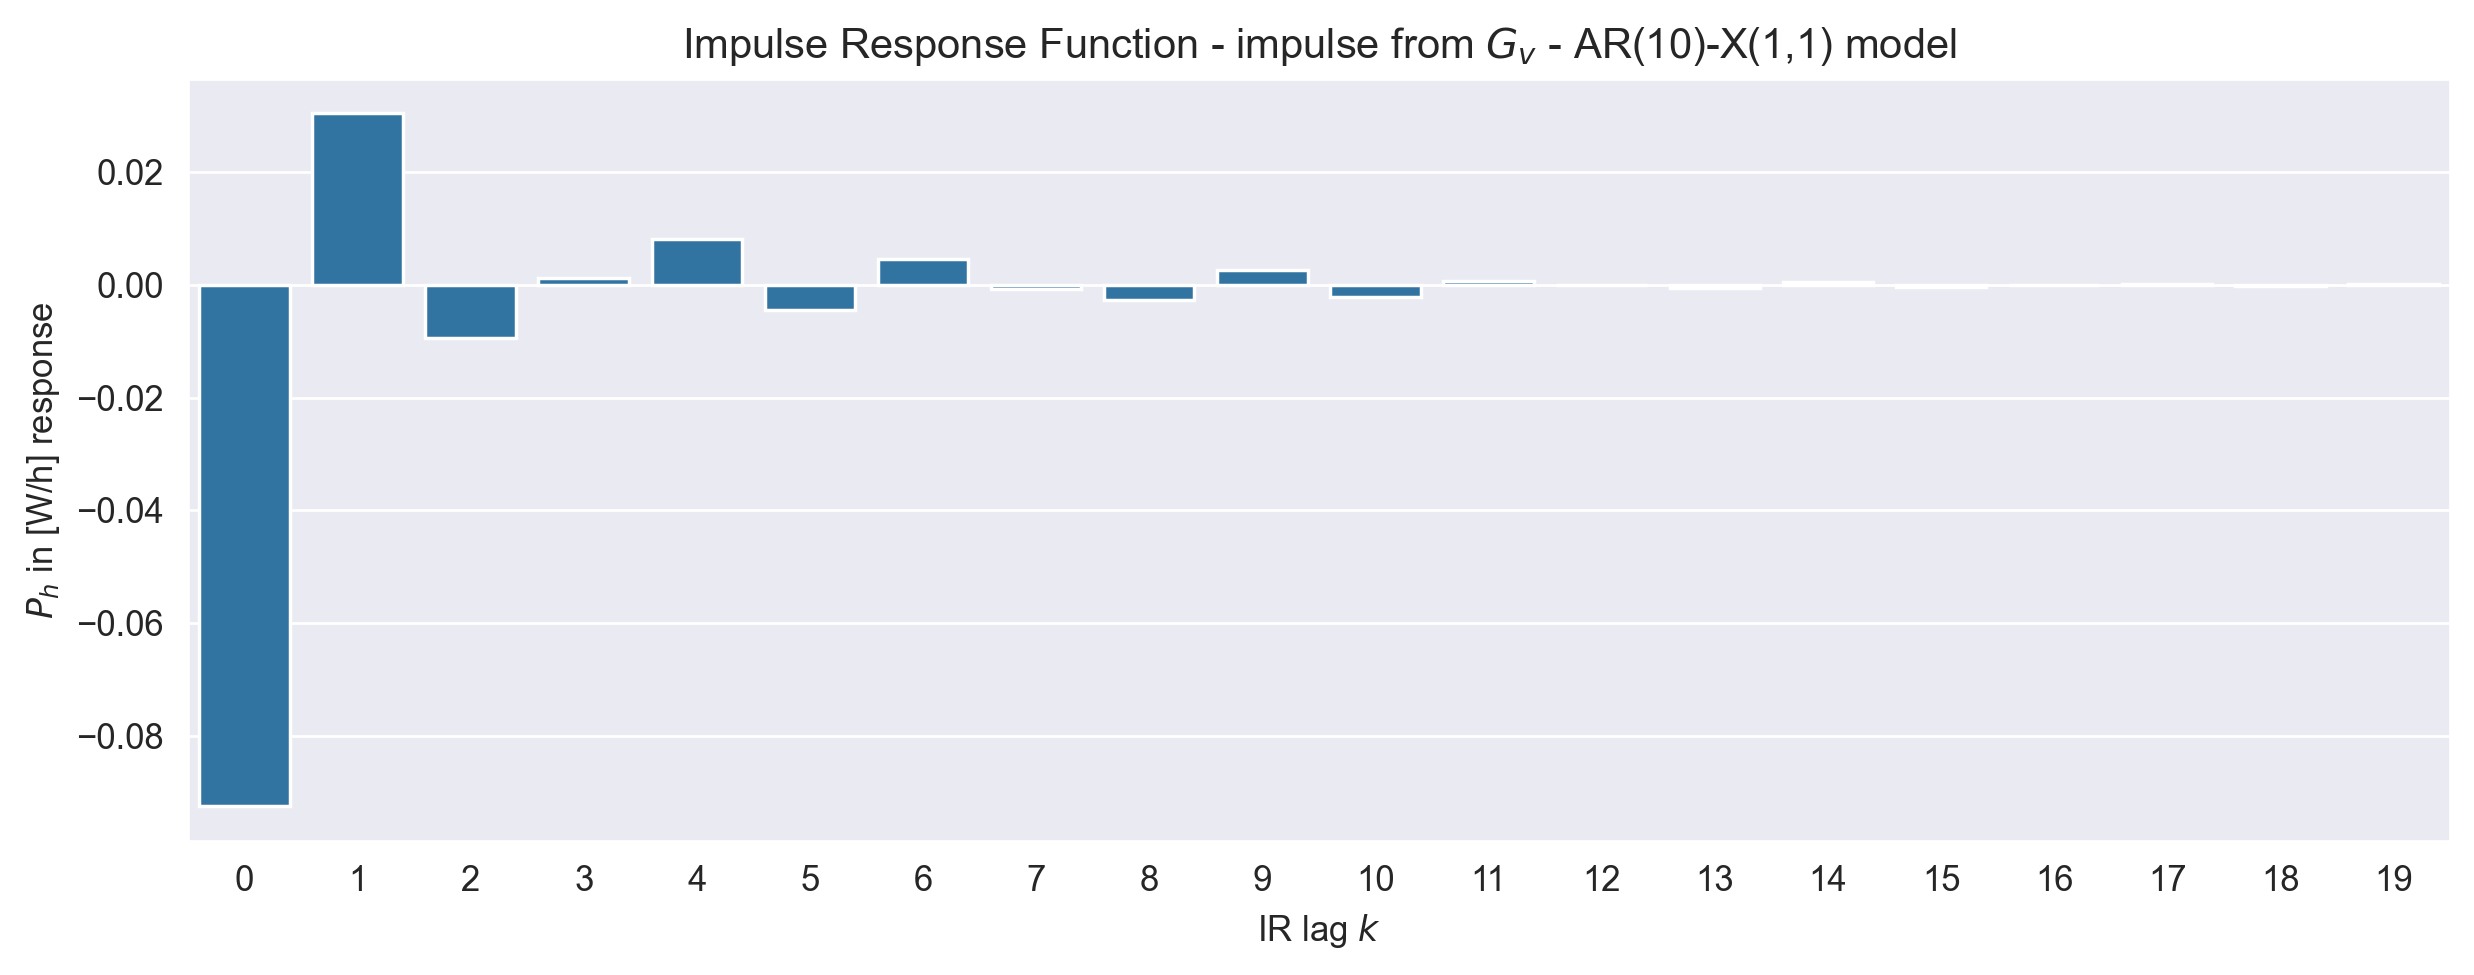

In [654]:
ir0 = Theta[-1] # G_v
ir = calculate_ar_impulse_response(-Theta.flatten()[1:-n_exog], nobs=20, unit_impulse=ir0)
plot_ir(ir, "impulse from $G_v$ - AR(10)-X(1,1)")

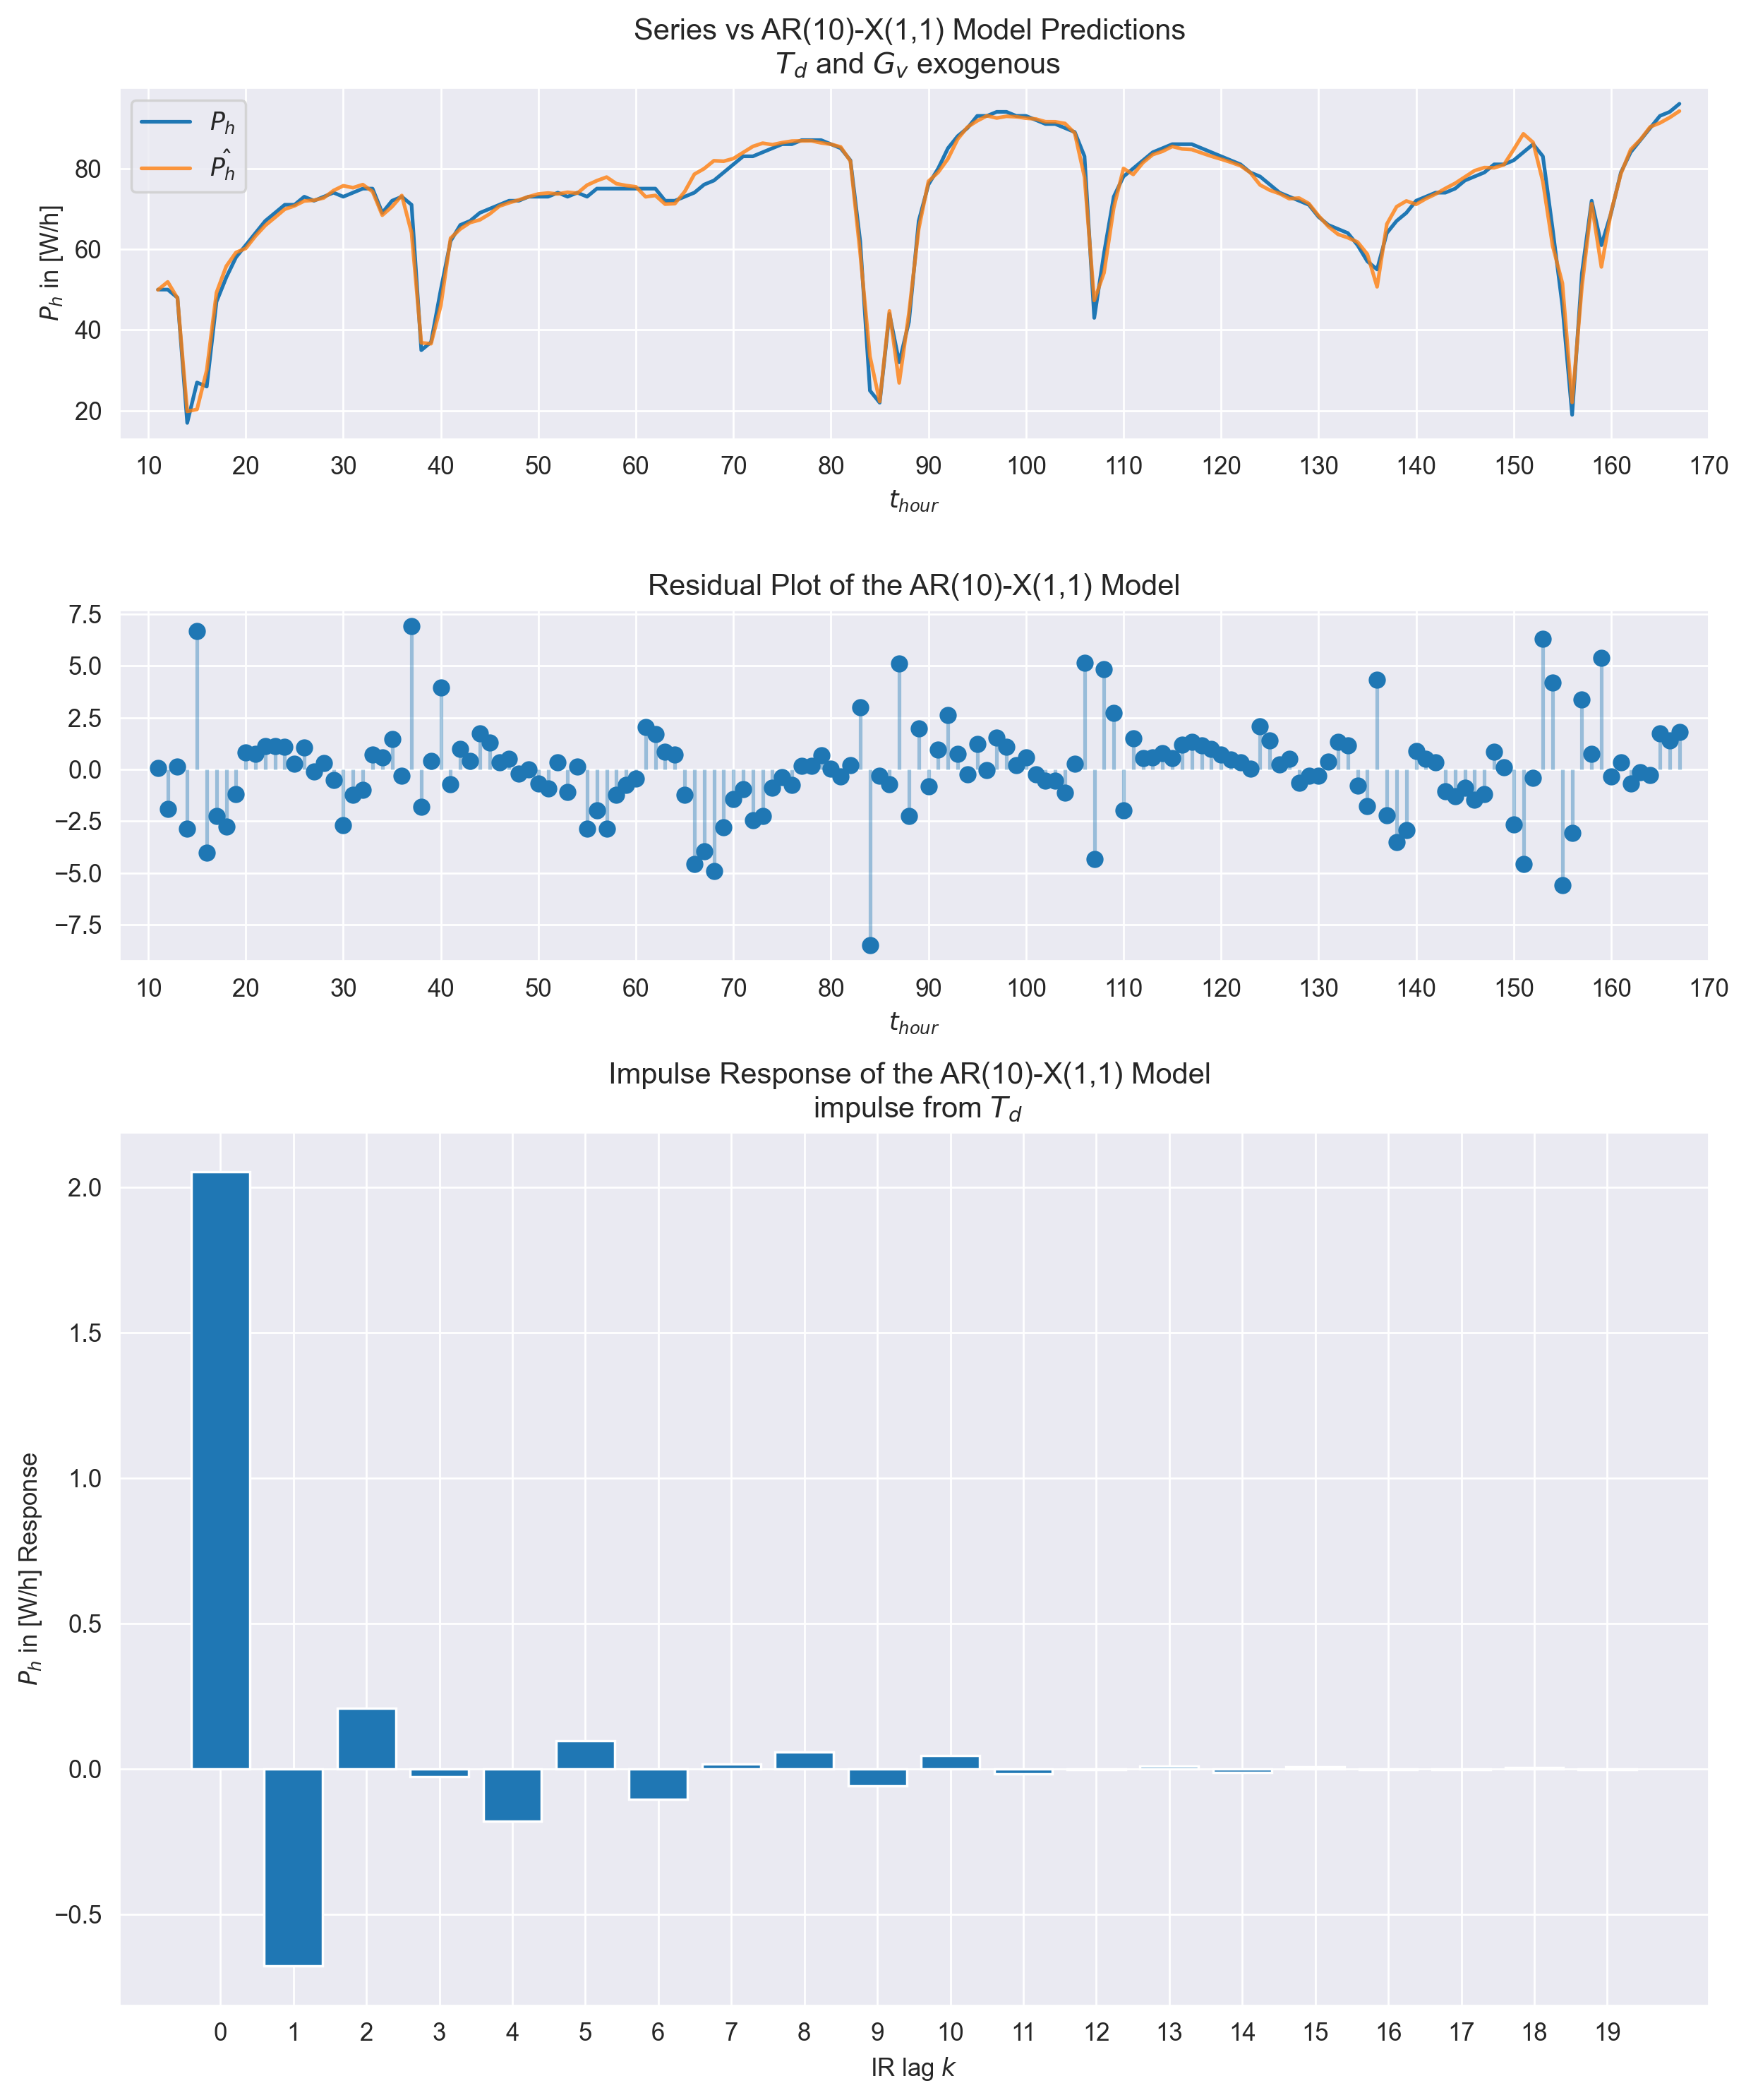

In [648]:
# plotting for report
plt.figure(figsize=(10,12), dpi=250)
ax1 = plt.subplot2grid(shape=(4,1), loc=(0,0))
ax2 = plt.subplot2grid(shape=(4,1), loc=(1,0))
ax3 = plt.subplot2grid(shape=(4,1), loc=(2,0), rowspan=2)

ax1.set_title("Series vs AR(10)-X(1,1) Model Predictions \n $T_d$ and $G_v$ exogenous")
ax1.plot(df_train.thour[p:], Y, label='$P_h$')
ax1.plot(df_train.thour[p:], X@Theta, label='$\hat{P_h}$', alpha=0.8)
ax1.set_xlabel("$t_{hour}$")
ax1.set_xticks(np.arange(p, len(df_train)+p, 10))
ax1.set_xlim((p-3, 170))
ax1.set_ylabel("$P_h$ in [W/h]")
ax1.legend()

ax2.set_title("Residual Plot of the AR(10)-X(1,1) Model")
ax2.scatter(df_train.thour[p:], Y-(X@Theta))
ax2.vlines(df_train.thour[p:], [min(res, 0) for res in (Y-X@Theta)], [max(res, 0) for res in (Y-X@Theta)], alpha=0.4)
ax2.plot(np.zeros_like(len(Y)))
ax2.set_xlabel("$t_{hour}$")
ax2.set_xticks(np.arange(p, len(df_train)+p, 10))
ax2.set_xlim((p-3, 170))

ax3.set_title("Impulse Response of the AR(10)-X(1,1) Model \n impulse from $T_d$")
ax3.bar(range(len(ir)), ir)
ax3.set_xlabel("IR lag $k$")
ax3.set_ylabel("$P_h$ in [W/h] Response")
ax3.set_xticks(np.arange(20))

plt.tight_layout()

Okay...maybe $p=10$ for the AR part is a bit overkill. A different interpretation of his task could be a simple AR(1)-X(1,1) model and the estimated impulse response. So we have:

$$P_t = -\phi_1 P_{t-1} + \omega_1 T_t + \beta_1 G_t + \varepsilon_t$$

where we model a unit impulse from $T_t$ with the response for $k=10$ as the lag, so:

$$\begin{align*}
\mathrm{\text{IR}}(0) & = 0\phi_{1} + 1\omega_{1} + 0\beta_{1} \\
\mathrm{\text{IR}}(1) & = \mathrm{\text{IR}}(0)\phi_{1} + \mathrm{\text{IR}}(0)\omega_{1} + \mathrm{\text{IR}}(0)\beta_{1} \\
\mathrm{\text{IR}}(2) & = \mathrm{\text{IR}}(1)\phi_{1} + 0\omega_{1} + 0\beta_{1} \\
\mathrm{\text{IR}}(3) & = \mathrm{\text{IR}}(2)\phi_{1} + 0\omega_{1} + 0\beta_{1} \\
 & \vdots \\
\mathrm{\text{IR}}(k = 10) & = \mathrm{\text{IR}}(9)\phi_{1} + 0\omega_{1} + 0\beta_{1}
\end{align*}$$

In [846]:
p, order = 3, 1
y = df_train.Ph.to_numpy()[order:].reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:,0] = df_train.Ph.to_numpy()[:-order]
X[:,1] = df_train.Tdelta.to_numpy()[order:]
X[:,2] = df_train.Gv.to_numpy()[order:]
omega = np.linalg.inv(X.T@X)@X.T@y
#omega[0] *= (-1)
print(omega.round(4).flatten())

[ 0.4127  2.3352 -0.0836]


IRF coefficients v_k:  [[2.3352], [-0.9637], [0.3977], [-0.1641], [0.0677], [-0.0279], [0.0115], [-0.0048], [0.002], [-0.0008]]


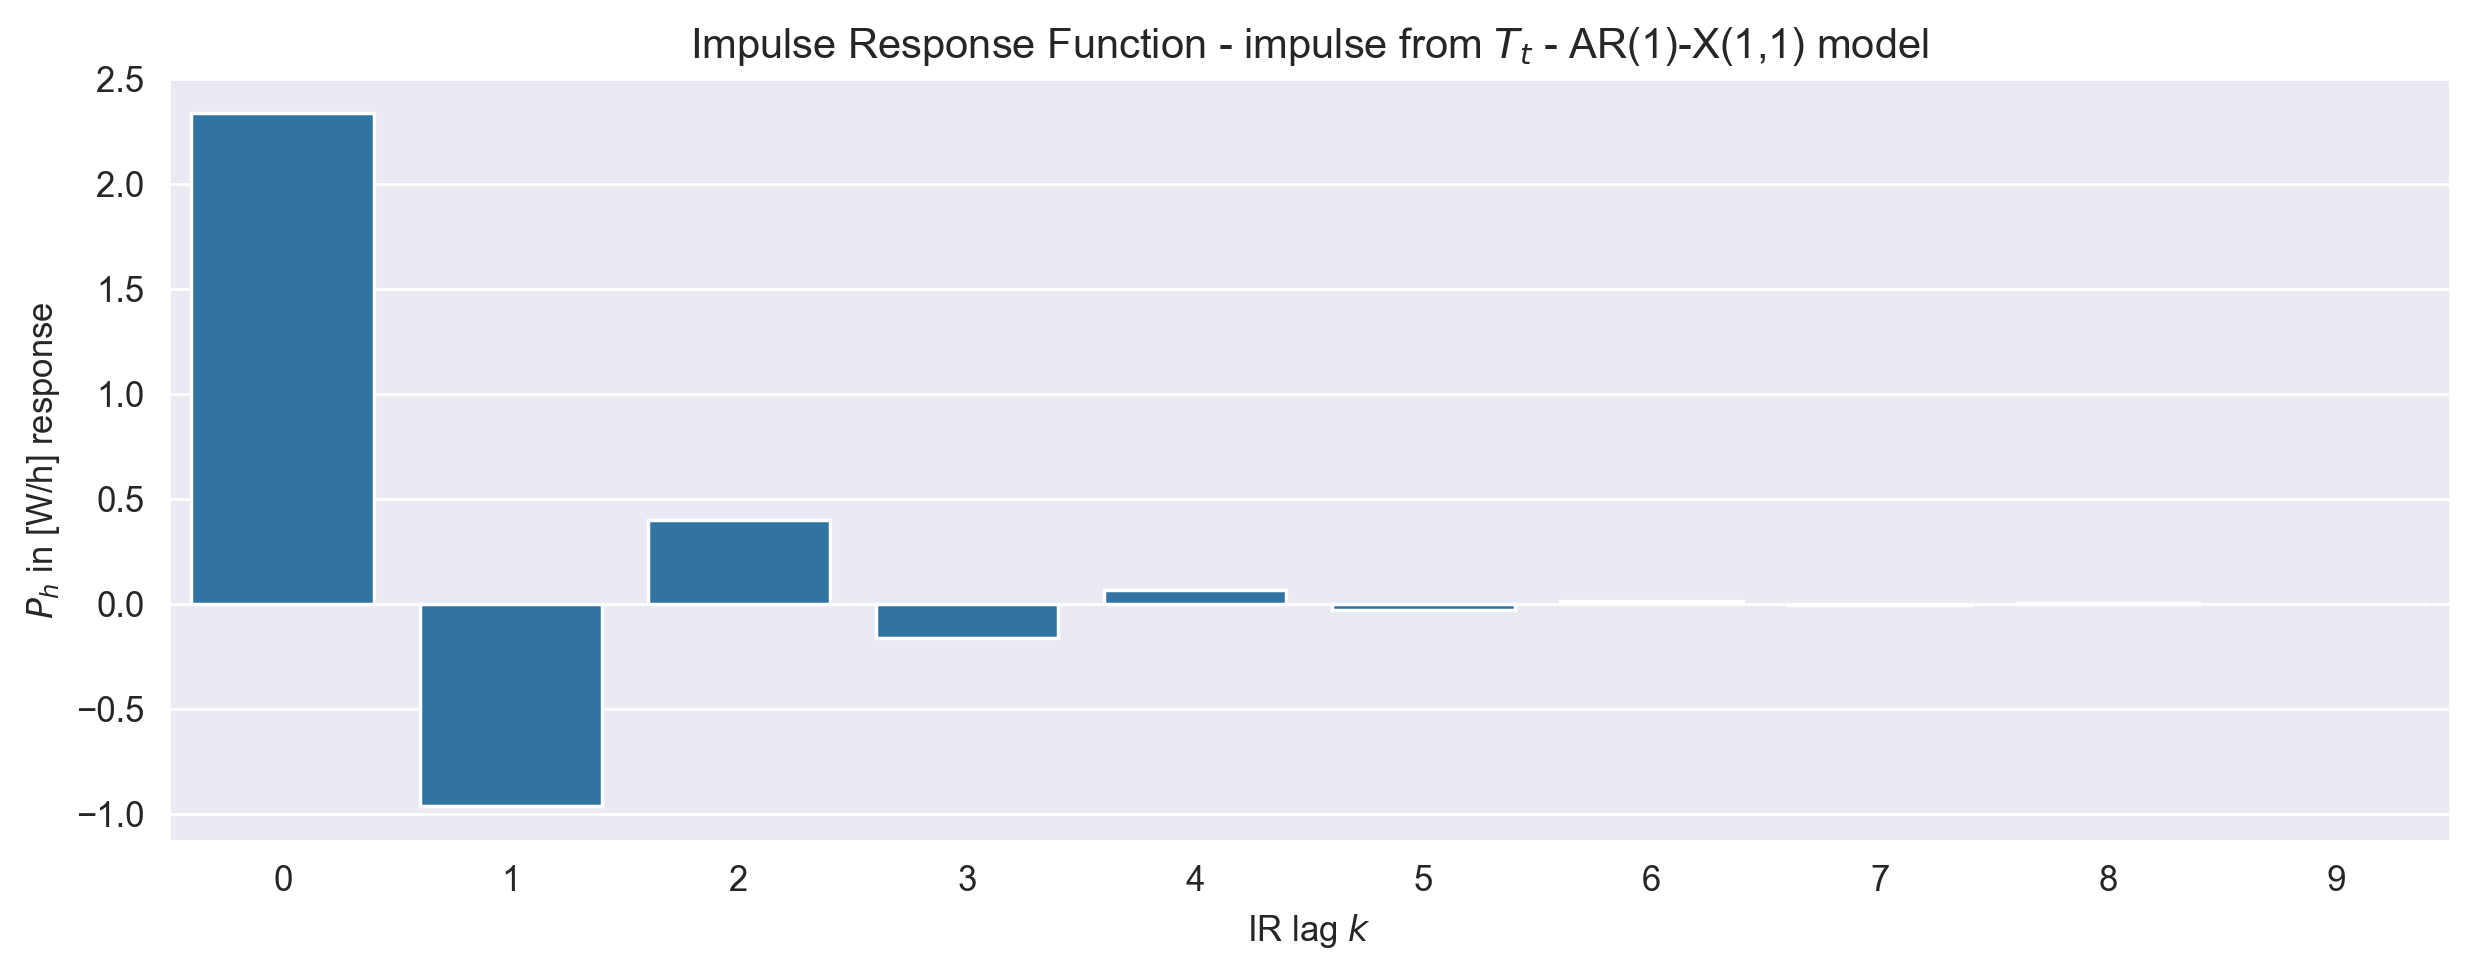

In [863]:
ir0 = omega[1] # omega_1 - impulse from T_t
ir = calculate_ar_impulse_response(ar_params=-omega[0], nobs=10, unit_impulse=ir0)
plot_ir(ir, "impulse from $T_t$ - AR(1)-X(1,1)")
print("IRF coefficients v_k: ", ir.round(4).reshape(-1,1).tolist())

IRF coefficients v_k:  [[-0.0836], [0.0345], [-0.0142], [0.0059], [-0.0024], [0.001], [-0.0004], [0.0002], [-0.0001], [0.0]]


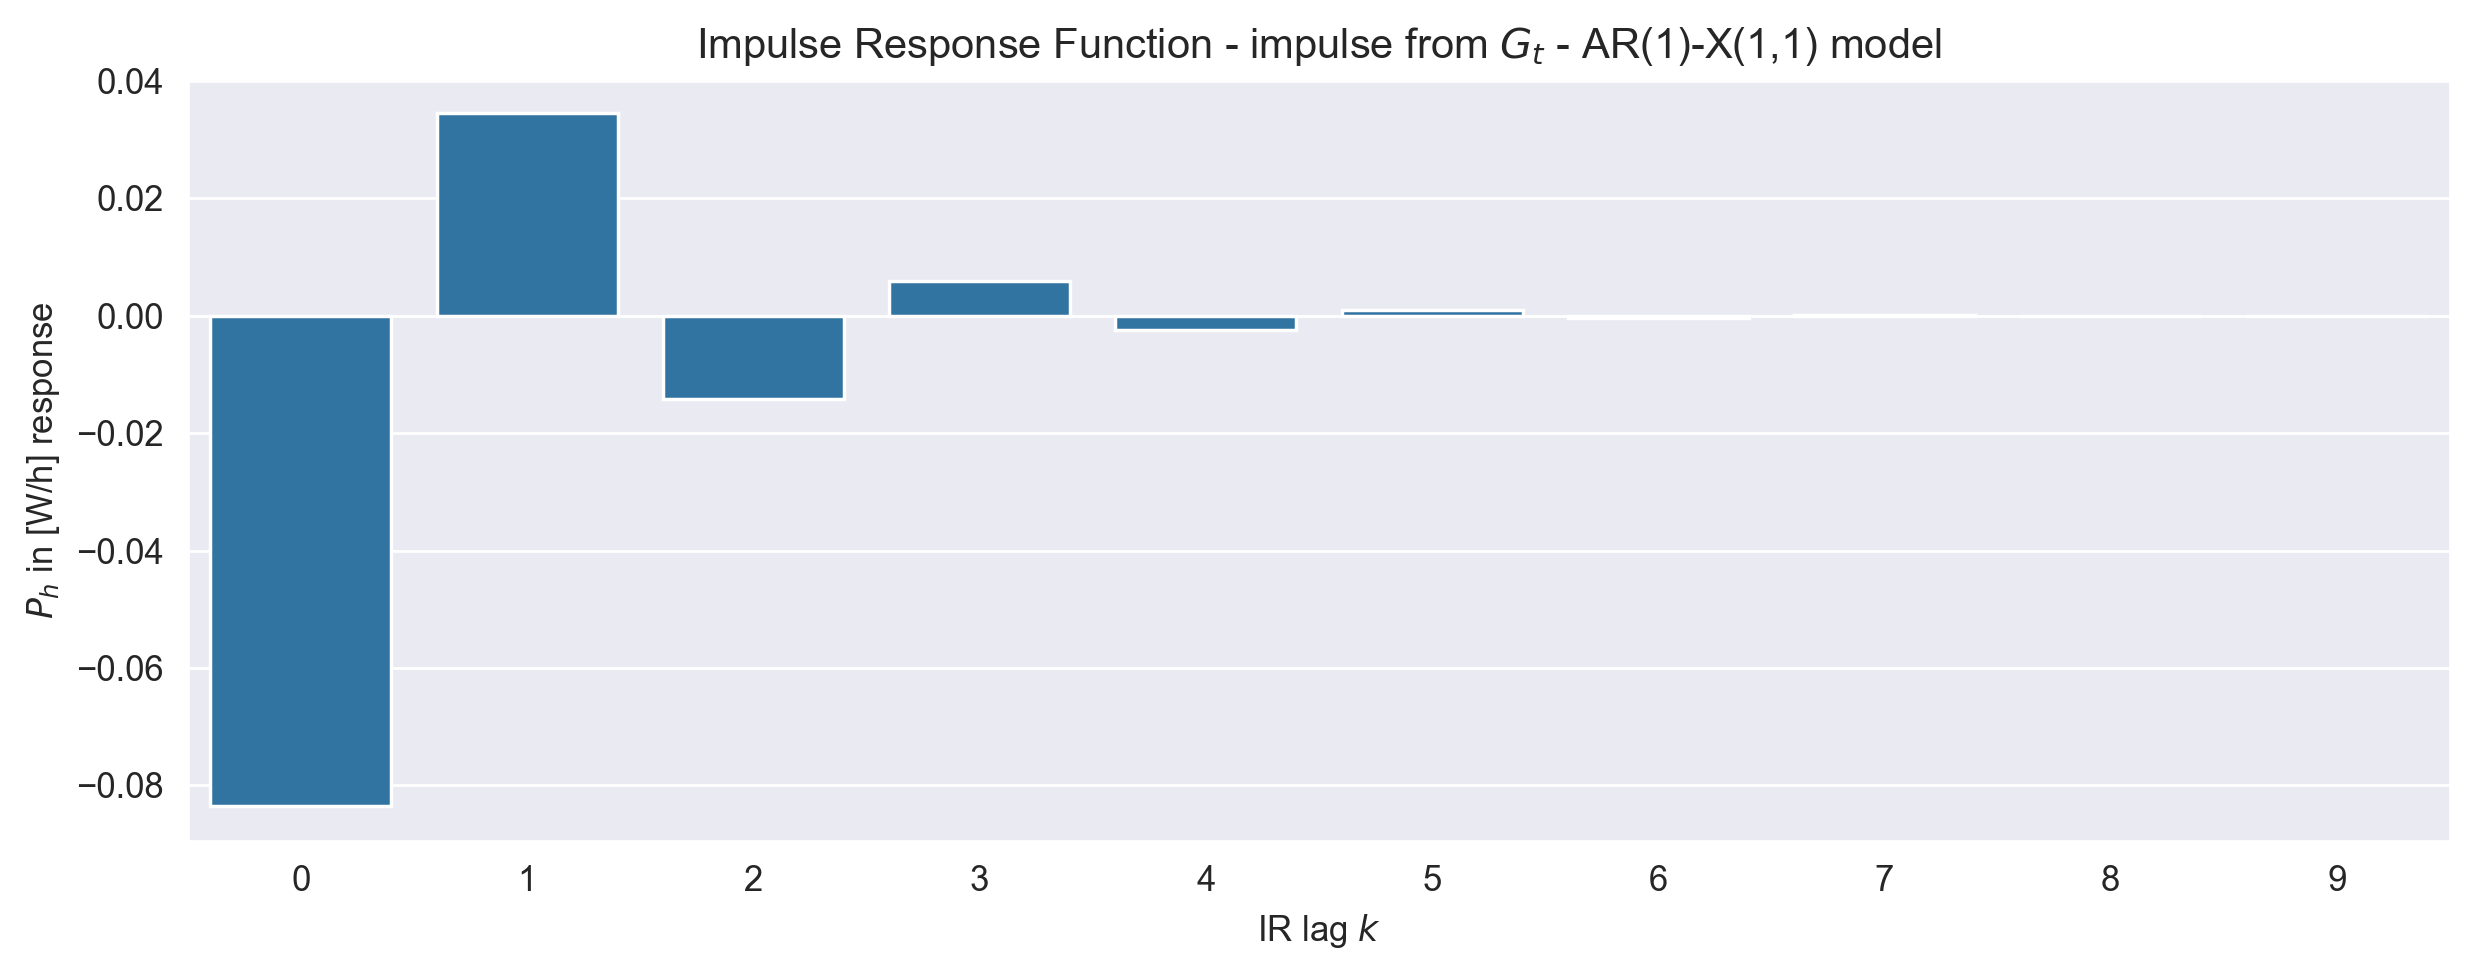

In [865]:
ir0 = omega[2] # omega_1 - impulse from G_t
ir = calculate_ar_impulse_response(ar_params=-omega[0], nobs=10, unit_impulse=ir0)
plot_ir(ir, "impulse from $G_t$ - AR(1)-X(1,1)")
print("IRF coefficients v_k: ", ir.round(4).reshape(-1,1).tolist())

We can deduce, the process is stable, because with the IRF coefficients $v_k = 

##### 3.5 - linear regression

For the OLS model we have:

$$P_t = c + \omega_1 T_t + \beta_1 G_t + \varepsilon_t$$

with the design matrix: $X = [1, T_{t}, G_{t}]$ for the column-vectors and with $\Theta = [c, \omega_1, \beta_1]^T$ as parameter vector.

In [241]:
import numpy as np

y = df_train.Ph.to_numpy().reshape(-1,1)
X = np.ones((y.shape[0], 3))
X[:, 1] = df_train.Tdelta.to_numpy()
X[:, 2] = df_train.Gv.to_numpy()

# since error is assumed 0-centered normal i.i.d., can ignore in regression model
omega = np.linalg.inv(X.T@X)@X.T@y
omega

array([[11.14841928],
       [ 3.33574297],
       [-0.1114136 ]])

Now do it without the intercept! Hence:

$$\begin{align*}
&& P_t &= \omega_1 T_t + \beta_1 G_t + \varepsilon_t \\
\Rightarrow && X &= [1, T_{t}, G_{t}] \\
\Rightarrow && \Theta &= [c, \omega_1, \beta_1]^T \\
\end{align*}$$


In [876]:
p, y = 2, df_train.Ph.to_numpy().reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:, 0] = df_train.Tdelta.to_numpy()
X[:, 1] = df_train.Gv.to_numpy()

# since error is assumed 0-centered normal i.i.d., can ignore in regression model
omega = np.linalg.inv(X.T@X)@X.T@y
print(omega.round(4).flatten())
print("RMSE: ", np.sqrt(np.mean((y-(X@omega))**2)))

[ 3.8948 -0.1099]
RMSE:  5.407193025780593


What to analyse?
- one-step predictions (explained)
    - not exactly "prediction" because they are on the training data
    - continously re-fit the model (basically a rolling window of including more and more values in the OLS model)
    - predict the next time step
    - one-step predictions, and then compare them to what? the test dataset? -> not explicitely told!
- ACF plot of the predictions of OLS model (interesting because no AR component in model)
- CCF plot between $P_h$ and $\hat{P_h}$
- analyse residuals between $P_h$ and $\hat{P_h}$
- WITHOUT THE INTERCEPT?!

In [877]:
# RLS one-step predictions on training dataset

p = 2 # number of parameters for the OLS model
thetas = np.zeros((X.shape[0], p))
for t in range(1,X.shape[0]):
    Xt, yt = X[:t], y[:t]
    theta = np.linalg.inv(Xt.T@Xt)@Xt.T@yt
    thetas[t] = theta.reshape(-1,)

# only for an RLS setting where re-fitting on most recent data and predictions!! 
def RLS_OneStepPrediction(X, y, thetas, t):
    y_pred = X[t+1]@thetas[t]
    res = y_pred - y[t+1]
    return y_pred, float(res[0])


In [900]:
# generic one-step predictions
def OneStepPrediction(X:np.ndarray, y:np.ndarray, theta:np.ndarray, t:int):
    assert theta.shape[1]==1
    assert y.shape[1]==1
    osp = X[t]@theta
    res = y[t]-osp
    return osp, res

os_pred = np.array([OneStepPrediction(X, y, omega, t)[0] for t in range(1,X.shape[0])]).reshape(-1,1)
print("OneStep RMSE: ", np.sqrt(np.mean((y[1:]-os_pred)**2)))

OneStep RMSE:  5.413058325943713


HUGE misunderstanding!!

One-Step predictions are just point wise evaluated predictions for each row in the design matrix. Hence, exactly equivalent to what I called the "full linear" or "full OLS" fit: $X \cdot \hat{\Theta} = \hat{y}_{\text{one-step}}$

So X@omega or X@theta.

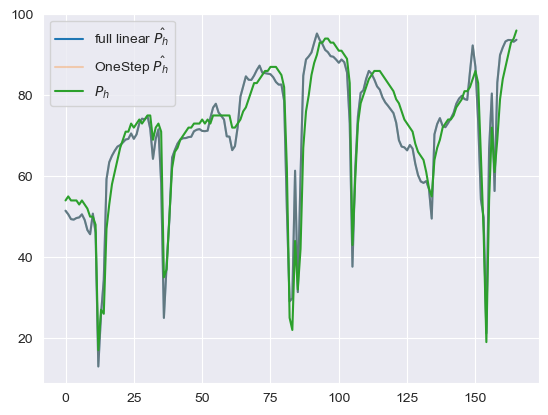

In [902]:
burn_in, os_offset = 0, 1
plt.plot((X@omega)[burn_in+os_offset:], label="full linear $\hat{P_h}$")
plt.plot(os_pred[burn_in:], label="OneStep $\hat{P_h}$", alpha=0.3)
plt.plot(df_train.Ph.to_numpy()[burn_in+os_offset:], label="$P_h$")
plt.legend()

In [909]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf

os_offset, burn_in = 1, 0

# plotting for report
def plot_model_res_ccf_acf_legacy(X, y, omega, os_pred:np.ndarray, ar_order:int=0):
    assert os_pred.shape[1]==1
    assert y.shape[1]==1

    fig = plt.figure(figsize=(10,14), dpi=250)
    #fig.subplots_adjust(hspace=0.5, wspace=3.5)
    ax1 = plt.subplot2grid(shape=(4,12), loc=(0,0), rowspan=1, colspan=12) # plot 3 series
    ax2 = plt.subplot2grid(shape=(4,12), loc=(1,0), rowspan=1, colspan=6) # os residuals
    ax3 = plt.subplot2grid(shape=(4,12), loc=(1,6), rowspan=1, colspan=6) # ols residuals
    ax4 = plt.subplot2grid(shape=(4,12), loc=(2,0), rowspan=1, colspan=6) # os acf
    ax5 = plt.subplot2grid(shape=(4,12), loc=(2,6), rowspan=1, colspan=6) # ols acf
    ax6 = plt.subplot2grid(shape=(4,12), loc=(3,0), rowspan=1, colspan=4) # ols-y ccf
    ax7 = plt.subplot2grid(shape=(4,12), loc=(3,4), rowspan=1, colspan=4) # os-y ccf
    ax8 = plt.subplot2grid(shape=(4,12), loc=(3,8), rowspan=1, colspan=4) # ols-os ccf

    ax1.set_title("Series and Predictions - Full Linear and OneStep")
    ax1.plot(df_train.thour[burn_in+os_offset+ar_order:], y[burn_in+os_offset:], label="$P_h$")
    ax1.plot(df_train.thour[burn_in+os_offset+ar_order:], (X@omega)[burn_in+os_offset:], label="$\hat{P}_h$ full linear", alpha=0.5)
    ax1.plot(df_train.thour[burn_in+os_offset+ar_order:], os_pred[burn_in:], label="$P_h$ OneStep", alpha=0.5)
    ax1.legend()
    ax1.set_xlabel("t_hour")
    ax1.set_ylabel("$P_h$ in [W/h]")

    ax2.set_title("Full Linear Model - Residuals")
    ax2.scatter(df_train.thour[burn_in+os_offset+ar_order:], (y-X@omega)[burn_in+os_offset:], color='blue')
    ax2.plot(np.zeros_like(df_train.thour[burn_in+os_offset+ar_order:]), c='black', alpha=0.2)
    ax2.vlines(df_train.thour[burn_in+os_offset+ar_order:], [min(0, res) for res in (y-X@omega)[burn_in+os_offset:]], [max(0, res) for res in (y-X@omega)[burn_in+os_offset:]], color='blue', alpha=0.5)
    ax2.set_xlabel("t_hour")
    
    ax3.set_title("One Step Predictions - Residuals")
    ax3.scatter(df_train.thour[burn_in+os_offset+ar_order:], y[burn_in+os_offset:]-os_pred[burn_in:], color='blue')
    ax3.plot(np.zeros_like(df_train.thour[burn_in+os_offset+ar_order:]), c='black', alpha=0.2)
    ax3.vlines(df_train.thour[burn_in+os_offset+ar_order:], [min(0, res) for res in (y[os_offset:]-os_pred)[burn_in:]], [max(0, res) for res in (y[os_offset:]-os_pred)[burn_in:]], color='blue', alpha=0.5)
    ax3.set_xlabel("t_hour")

    #ax4.set_title("ACF for Full Linear Model Residuals")
    plot_acf(y-(X@omega), ax=ax4, lags=X.shape[0]-10, title='ACF for Full Linear Model Residuals')
    ax4.set_xlabel("t_hour")
    ax4.set_ylabel("$P_h$ in [W/h]")

    #ax5.set_title("ACF for One Step Prediction Residuals")
    plot_acf(y[os_offset:]-os_pred, ax=ax5, lags=X.shape[0]-10, title='ACF for One Step Prediction Residuals')
    ax5.set_xlabel("t_hour")
    ax5.set_ylabel("$P_h$ in [W/h]")

    #ax6.set_title("CCF for $P_h$ and $\hat{P_h}$-Full Linear Model")
    plot_ccf(X@omega, y, ax=ax6, lags=X.shape[0]-10, title="CCF for $P_h$ and \n $\hat{P}_h$-Full Linear Model")
    ax6.set_xlabel("lag $k$")
    ax6.set_ylabel("$P_h$ in [W/h]")
    
    #ax7.set_title("CCF for $P_h$ and $\hat{P_h}$-One Step Predictions")
    plot_ccf(os_pred[burn_in:], y[os_offset+burn_in:], ax=ax7, lags=X.shape[0]-10, title='CCF for $P_h$ and \n $\hat{P}_h$-One Step Predictions')
    ax7.set_xlabel("lag $k$")
    ax7.set_ylabel("$P_h$ in [W/h]")
    
    #ax8.set_title("CCF for $\hat{P_h}$-Full Linear Model and $\hat{P_h}$-One Step Predictions")
    plot_ccf(os_pred[burn_in:], (X@omega)[os_offset+burn_in:], ax=ax8, lags=X.shape[0]-10, title='CCF for $\hat{P}_h$-Full Linear Model \n and $\hat{P}_h$-One Step Predictions');
    ax8.set_xlabel("lag $k$")
    ax8.set_ylabel("$P_h$ in [W/h]")

    plt.tight_layout()

# plotting for report
def plot_step_pred_res_ccf_acf(X:np.ndarray, y:np.ndarray, step_pred:np.ndarray, k:int=1, burn_in:int=2, ar_order:int=0):
    assert step_pred.shape[1]==1
    assert y.shape[1]==1
    os_offset = k

    fig = plt.figure(figsize=(10,8), dpi=250)
    #fig.subplots_adjust(hspace=0.5, wspace=3.5)
    ax1 = plt.subplot2grid(shape=(3,2), loc=(0,0), rowspan=1, colspan=2) # plot 2 series
    ax2 = plt.subplot2grid(shape=(3,2), loc=(1,0), rowspan=1, colspan=2) # step residuals
    ax3 = plt.subplot2grid(shape=(3,2), loc=(2,0), rowspan=1, colspan=1) # ols acf
    ax4 = plt.subplot2grid(shape=(3,2), loc=(2,1), rowspan=1, colspan=1) # ols-y ccf

    ax1.set_title(f"Series and {k}-step predictions")
    ax1.plot(df_train.thour[burn_in+os_offset+ar_order:], y[burn_in+os_offset:], label="$P_h$")
    ax1.plot(df_train.thour[burn_in+os_offset+ar_order:], step_pred[burn_in:], label=f"$\hat{{P}}_h$ {k}-step", alpha=0.5)
    ax1.legend()
    ax1.set_xlabel("t_hour")
    ax1.set_ylabel("$P_h$ in [W/h]")
    
    ax2.set_title(f"{k}-step residuals")
    ax2.scatter(df_train.thour[burn_in+os_offset+ar_order:], y[burn_in+os_offset:]-step_pred[burn_in:], color='blue')
    ax2.plot(np.zeros_like(df_train.thour[burn_in+os_offset+ar_order:]), c='black', alpha=0.2)
    ax2.vlines(df_train.thour[burn_in+os_offset+ar_order:], [min(0, res) for res in (y[os_offset:]-step_pred)[burn_in:]], [max(0, res) for res in (y[os_offset:]-step_pred)[burn_in:]], color='blue', alpha=0.5)
    ax2.set_xlabel("t_hour")

    #ax5.set_title("ACF for One Step Prediction Residuals")
    plot_acf(y[os_offset:]-step_pred, ax=ax3, lags=X.shape[0]-10, title=f'ACF for {k}-Step Prediction Residuals')
    ax3.set_ylabel("$P_h$ in [W/h]")
    ax3.set_xlabel("t_hour")
    
    #ax7.set_title("CCF for $P_h$ and $\hat{P_h}$-One Step Predictions")
    plot_ccf(step_pred[burn_in:], y[os_offset+burn_in:], ax=ax4, lags=X.shape[0]-10, title=f'CCF for $P_h$ and \n $\hat{{P}}_h$ {k}-Step Predictions')
    ax4.set_xlabel("lag $k$")
    ax4.set_ylabel("$P_h$ in [W/h]")

    plt.tight_layout()
    

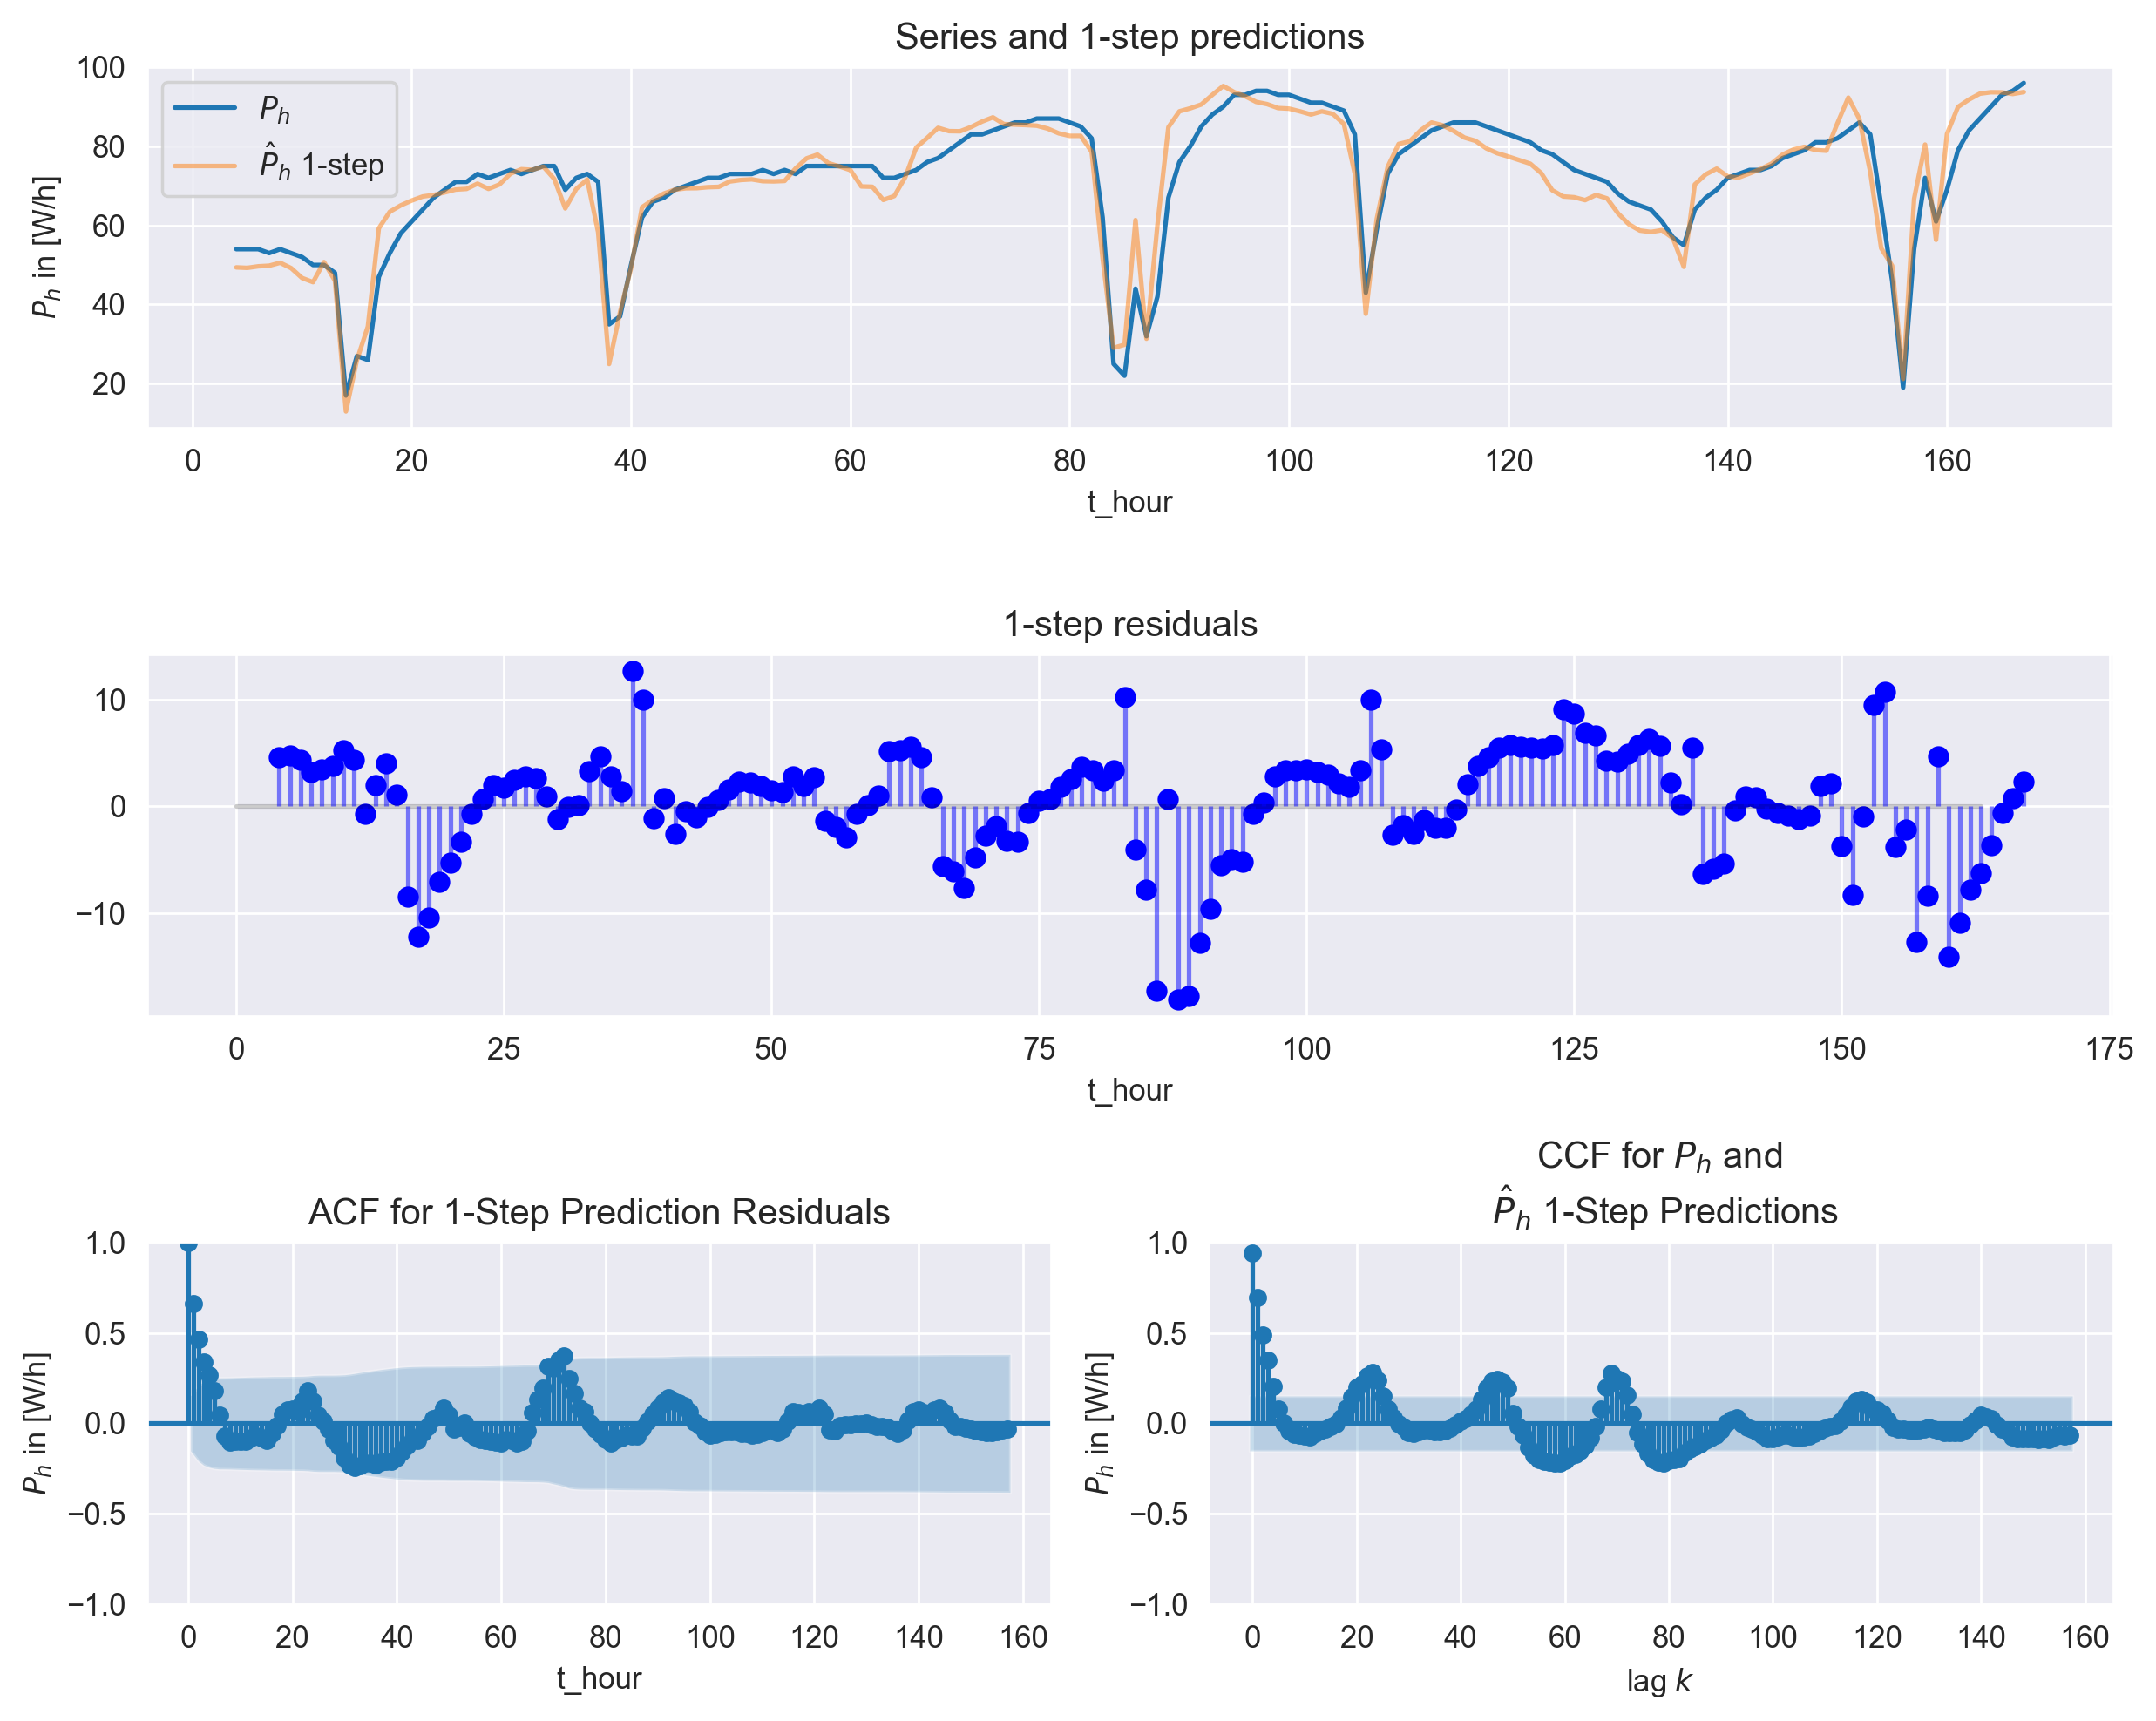

In [910]:
plot_step_pred_res_ccf_acf(X, y, np.array(os_pred).reshape(-1,1))

In [913]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = y-X@omega
acorr_ljungbox(x=residuals, auto_lag=True, boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,74.480196,6.124964e-18,73.158062,1.196718e-17
2,111.708053,5.532284e-25,109.504787,1.664706e-24
3,131.645287,2.390529e-28,128.852162,9.559311e-28
4,144.258397,3.457625e-30,141.017469,1.709247e-29
5,150.107395,1.266676e-30,146.624201,6.981389e-30
...,...,...,...,...
69,381.194398,9.752830e-45,317.384662,1.580013e-33
70,407.936087,3.559943e-49,332.733442,7.805615e-36
71,442.718529,4.011212e-55,352.491516,6.335235e-39
72,483.829369,2.625747e-62,375.601159,1.239755e-42


*Conclusion:*

- H_0: residuals are independently distributed.
- the p-values are much lower than 0.05 -> we reject the Null hypothesis
- the residuals are dependent, showing auto-correlation behaviour, thus systematic error in the model

*Observations:*
- TODO

*Need for a Transfer Function:*
TODO

##### 3.6 AR(1)-X(1,1) model

AR(1) model with 2 exogenous variables

$$P_t = - \phi_1 P_{t-1} + \omega_1 T_t + \beta_1 G_t + \varepsilon_t$$

In [959]:
p, order = 3, 1
y = df_train.Ph.to_numpy()[order:].reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:,0] = df_train.Ph.to_numpy()[:-order]
X[:,1] = df_train.Tdelta.to_numpy()[order:]
X[:,2] = df_train.Gv.to_numpy()[order:]
omega = np.linalg.inv(X.T@X)@X.T@y
#omega[0]*=(-1)

print("RMSE: ", np.sqrt(np.mean(y-X@omega)))
print(omega.round(4).flatten())

RMSE:  0.35347818010607646
[ 0.4127  2.3352 -0.0836]


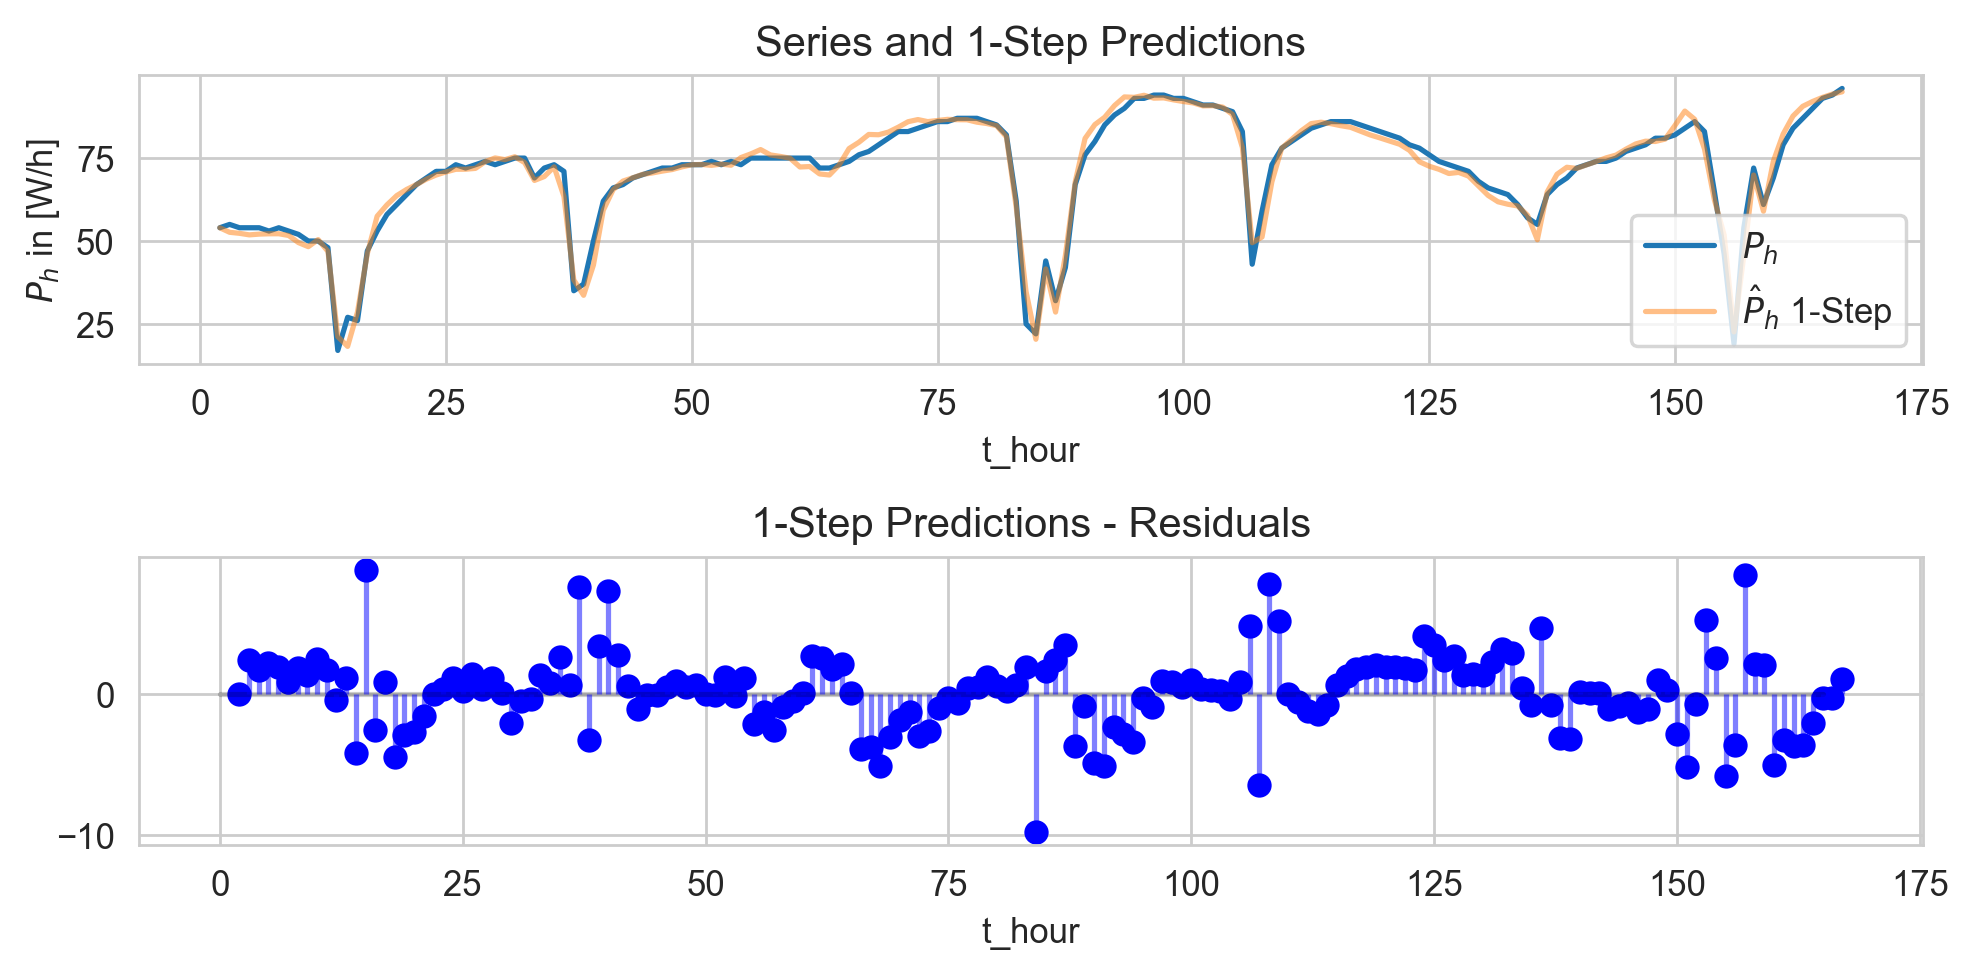

In [960]:
sns.set_style('whitegrid')

# one-step predictions on training dataset
p, ar_order, burn_in, os_offset = 3, 1, 0, 0
os_pred = X@omega

plt.figure(figsize=(8,4), dpi=250)
plt.subplot(2,1,1)
plt.title("Series and 1-Step Predictions")
plt.plot(df_train.thour[burn_in+os_offset+ar_order:], y[burn_in+os_offset:], label="$P_h$")
plt.plot(df_train.thour[burn_in+os_offset+ar_order:], os_pred[burn_in:], label="$\hat{P}_h$ 1-Step", alpha=0.5)
plt.legend()
plt.xlabel("t_hour")
plt.ylabel("$P_h$ in [W/h]")

plt.subplot(2,1,2)
plt.title("1-Step Predictions - Residuals")
plt.scatter(df_train.thour[burn_in+os_offset+ar_order:], (y[os_offset:]-os_pred)[burn_in:], color='blue')
plt.plot(np.zeros_like(df_train.thour[burn_in+os_offset+ar_order:]), c='black', alpha=0.2)
plt.vlines(df_train.thour[burn_in+os_offset+ar_order:], [min(0, res) for res in (y[os_offset:]-os_pred)[burn_in:]], [max(0, res) for res in (y[os_offset:]-os_pred)[burn_in:]], color='blue', alpha=0.5)
plt.xlabel("t_hour")

plt.tight_layout()

In [920]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = y-X@omega
acorr_ljungbox(x=residuals, auto_lag=True, boxpierce=True, return_df=True)#.head()

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,6.802253,0.009104,6.680784,0.009746
2,10.342797,0.005677,10.137030,0.006292
3,10.599212,0.014103,10.385813,0.015556


*Conclude:*
- p-value < 0.05 -> reject H_0 -> residuals not independent -> auto-correlation behaviour
- begins to improve, since for lag = 3 shows 0.01 significance

##### 3.7 ARX(2; 2) model

AR(2) model with 2 exogenous variables (full exo)

$$P_t = - \phi_1 P_{t-1} - \phi_2 P_{t-2} + \omega_1 T_t + \omega_2 T_{t-1} + \beta_1 G_t + \beta_2 G_{t-1} + \varepsilon_t$$

In [961]:
p, order = 6, 2
y = df_train.Ph.to_numpy()[order:].reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:,0] = df_train.Ph.to_numpy()[1:-order+1]     # phi_1
X[:,1] = df_train.Ph.to_numpy()[:-order]        # phi_2
X[:,2] = df_train.Tdelta.to_numpy()[order:]     # omega_1
X[:,3] = df_train.Tdelta.to_numpy()[1:-order+1] # omega_2
X[:,4] = df_train.Gv.to_numpy()[order:]         # beta_1
X[:,5] = df_train.Gv.to_numpy()[1:-order+1]     # beta_2
omega = np.linalg.inv(X.T@X)@X.T@y
#omega[0]*=(-1)

RMSE:  0.28420949689810077
[ 0.6274 -0.055   0.2704  1.4412 -0.0991  0.037 ]


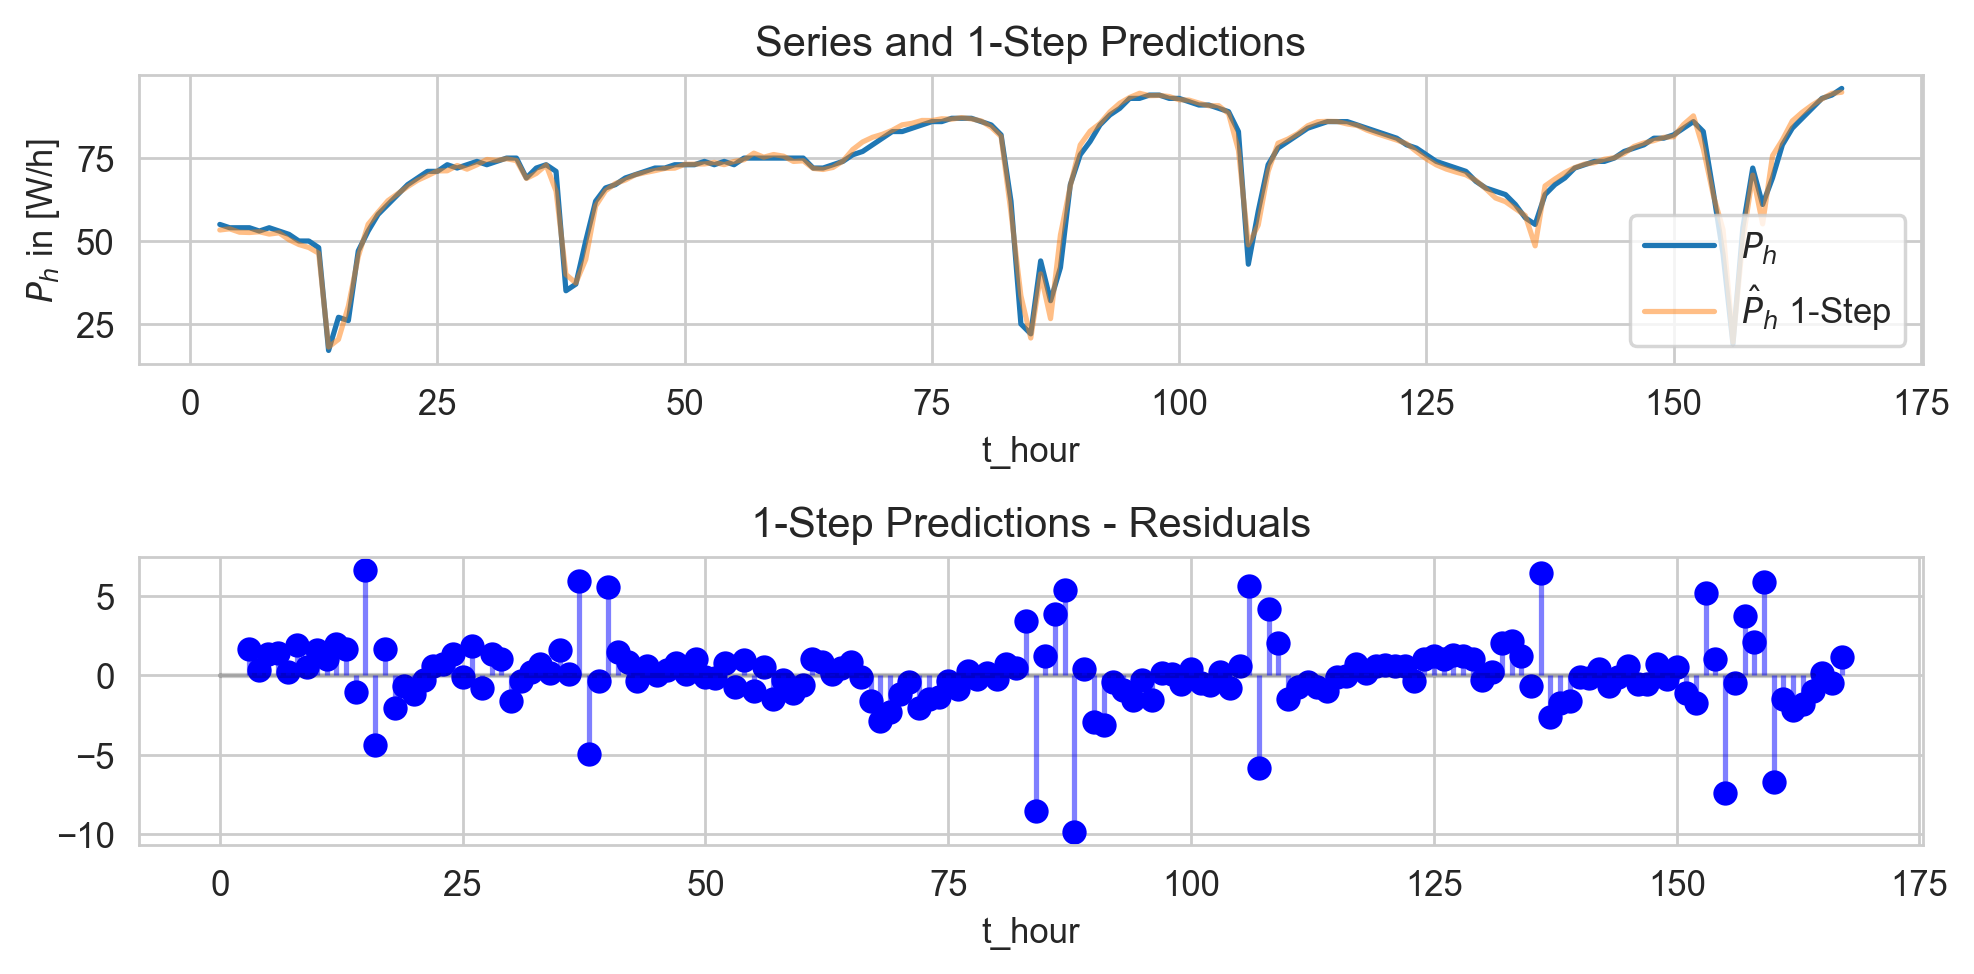

In [962]:
# one-step predictions on training dataset
p, ar_order, burn_in, os_offset = 6, 2, 0, 0
os_pred = X@omega


plt.figure(figsize=(8,4), dpi=250)
plt.subplot(2,1,1)
plt.title("Series and 1-Step Predictions")
plt.plot(df_train.thour[burn_in+os_offset+ar_order:], y[burn_in+os_offset:], label="$P_h$")
plt.plot(df_train.thour[burn_in+os_offset+ar_order:], os_pred[burn_in:], label="$\hat{P}_h$ 1-Step", alpha=0.5)
plt.legend()
plt.xlabel("t_hour")
plt.ylabel("$P_h$ in [W/h]")

plt.subplot(2,1,2)
plt.title("1-Step Predictions - Residuals")
plt.scatter(df_train.thour[burn_in+os_offset+ar_order:], (y[os_offset:]-os_pred)[burn_in:], color='blue')
plt.plot(np.zeros_like(df_train.thour[burn_in+os_offset+ar_order:]), c='black', alpha=0.2)
plt.vlines(df_train.thour[burn_in+os_offset+ar_order:], [min(0, res) for res in (y[os_offset:]-os_pred)[burn_in:]], [max(0, res) for res in (y[os_offset:]-os_pred)[burn_in:]], color='blue', alpha=0.5)
plt.xlabel("t_hour")

plt.tight_layout()

print("RMSE: ", np.sqrt(np.mean(y-X@omega)))
print(omega.round(4).flatten())

In [934]:
residuals = y-X@omega
acorr_ljungbox(x=residuals, auto_lag=True, boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,5.07649,0.024252,4.985296,0.025564


*Conclusion:*
- at lag = 1 is already 0.01 significant
- almost fail to reject H_0

Concerning the AIC and BIC:

- the log-likelihood is a conditional log-normal (standard Gaussian)
    - documentation for [```statsmodels...AutoReg```](https://www.statsmodels.org/v0.11.1/generated/statsmodels.tsa.ar_model.AutoReg.loglike.html#statsmodels.tsa.ar_model.AutoReg.loglike) with the actual formula in the [source](https://www.statsmodels.org/v0.11.1/_modules/statsmodels/tsa/ar_model.html#AutoReg.loglike)
- the general AIC, BIC, HQIC given in [docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.info_criteria.html) as:

$$\begin{split}
AIC & = -2 \log L(\mathbf{Y} | \mathbf{\hat{\psi}}) + 2 p \\
BIC & = -2 \log L(\mathbf{Y} | \mathbf{\hat{\psi}}) + p \log n \\
HQIC & = -2 \log L(\mathbf{Y} | \mathbf{\hat{\psi}}) + 2 p \log \log n \\
\end{split}$$

NUMBER EQUATIONS IN REPORT

with the log-likelihood as:

$$\log L(\mathbf{Y} | \mathbf{\hat{\psi}}) = - \frac{n}{2} \Big[ \log(2 \pi) + \log \Big( \frac{(\mathbf{Y} - \mathbf{\hat{Y}})^2}{n} \Big) +1 \Big]$$

for $\mathbf{\hat{\psi}}$ as the MLE estimated parameters, $\mathbf{Y}$ as the target/modeled time-series, $n$ as the number of observations and $p$ as the number of parameters. In our case for the ARX model, since we only have an AR part, the MLE becomes an OLS estimation, hence: 

$$\mathbf{\hat{\psi}} = \hat{\Theta} = [- \hat{\phi_1}, - \hat{\phi_2}, \hat{\omega_1}, \hat{\omega_2}, \hat{\beta_1}, \hat{\beta_2}]^T$$


In [819]:
# AIC, BIC and HQIC
def aic_bic_hqic(X, y, param_est):
    n, p = y.shape[0], param_est.shape[0]
    residuals = y - X@param_est
    ssr = residuals.T@residuals
    log_likelihood = -(n / 2) * (np.log(2 * np.pi) + np.log(ssr / n) + 1)

    aic = -2*log_likelihood+2*p
    bic = -2*log_likelihood+(p*np.log(n))
    hqic = -2*log_likelihood+(2*p*np.log(np.log(n)))
    return aic, bic, hqic

**Common Notation for ARX models' exogenous parts:**

To define a clear and common generic notation for ARX models with multiple exogenous variables, we set:

$$\text{AR}(p)-\text{X}(e_1, e_2, ...)$$

where $p$ is as in most literature, the order of the AR part of the model, $e_1$ is the order of the first exogenous variable, $e_2$ the order of the second exogenous variable and so on. Formally, we have:

$$Y_t = c - \sum_{i=1}^p \phi_i Y_{t-i} + \sum_{i=0}^{e_1} \omega_{1,i+1} X_{1,t-i} + \sum_{i=0}^{e_2} \omega_{2,i+1} X_{2,t-i} + ... + \varepsilon_t$$

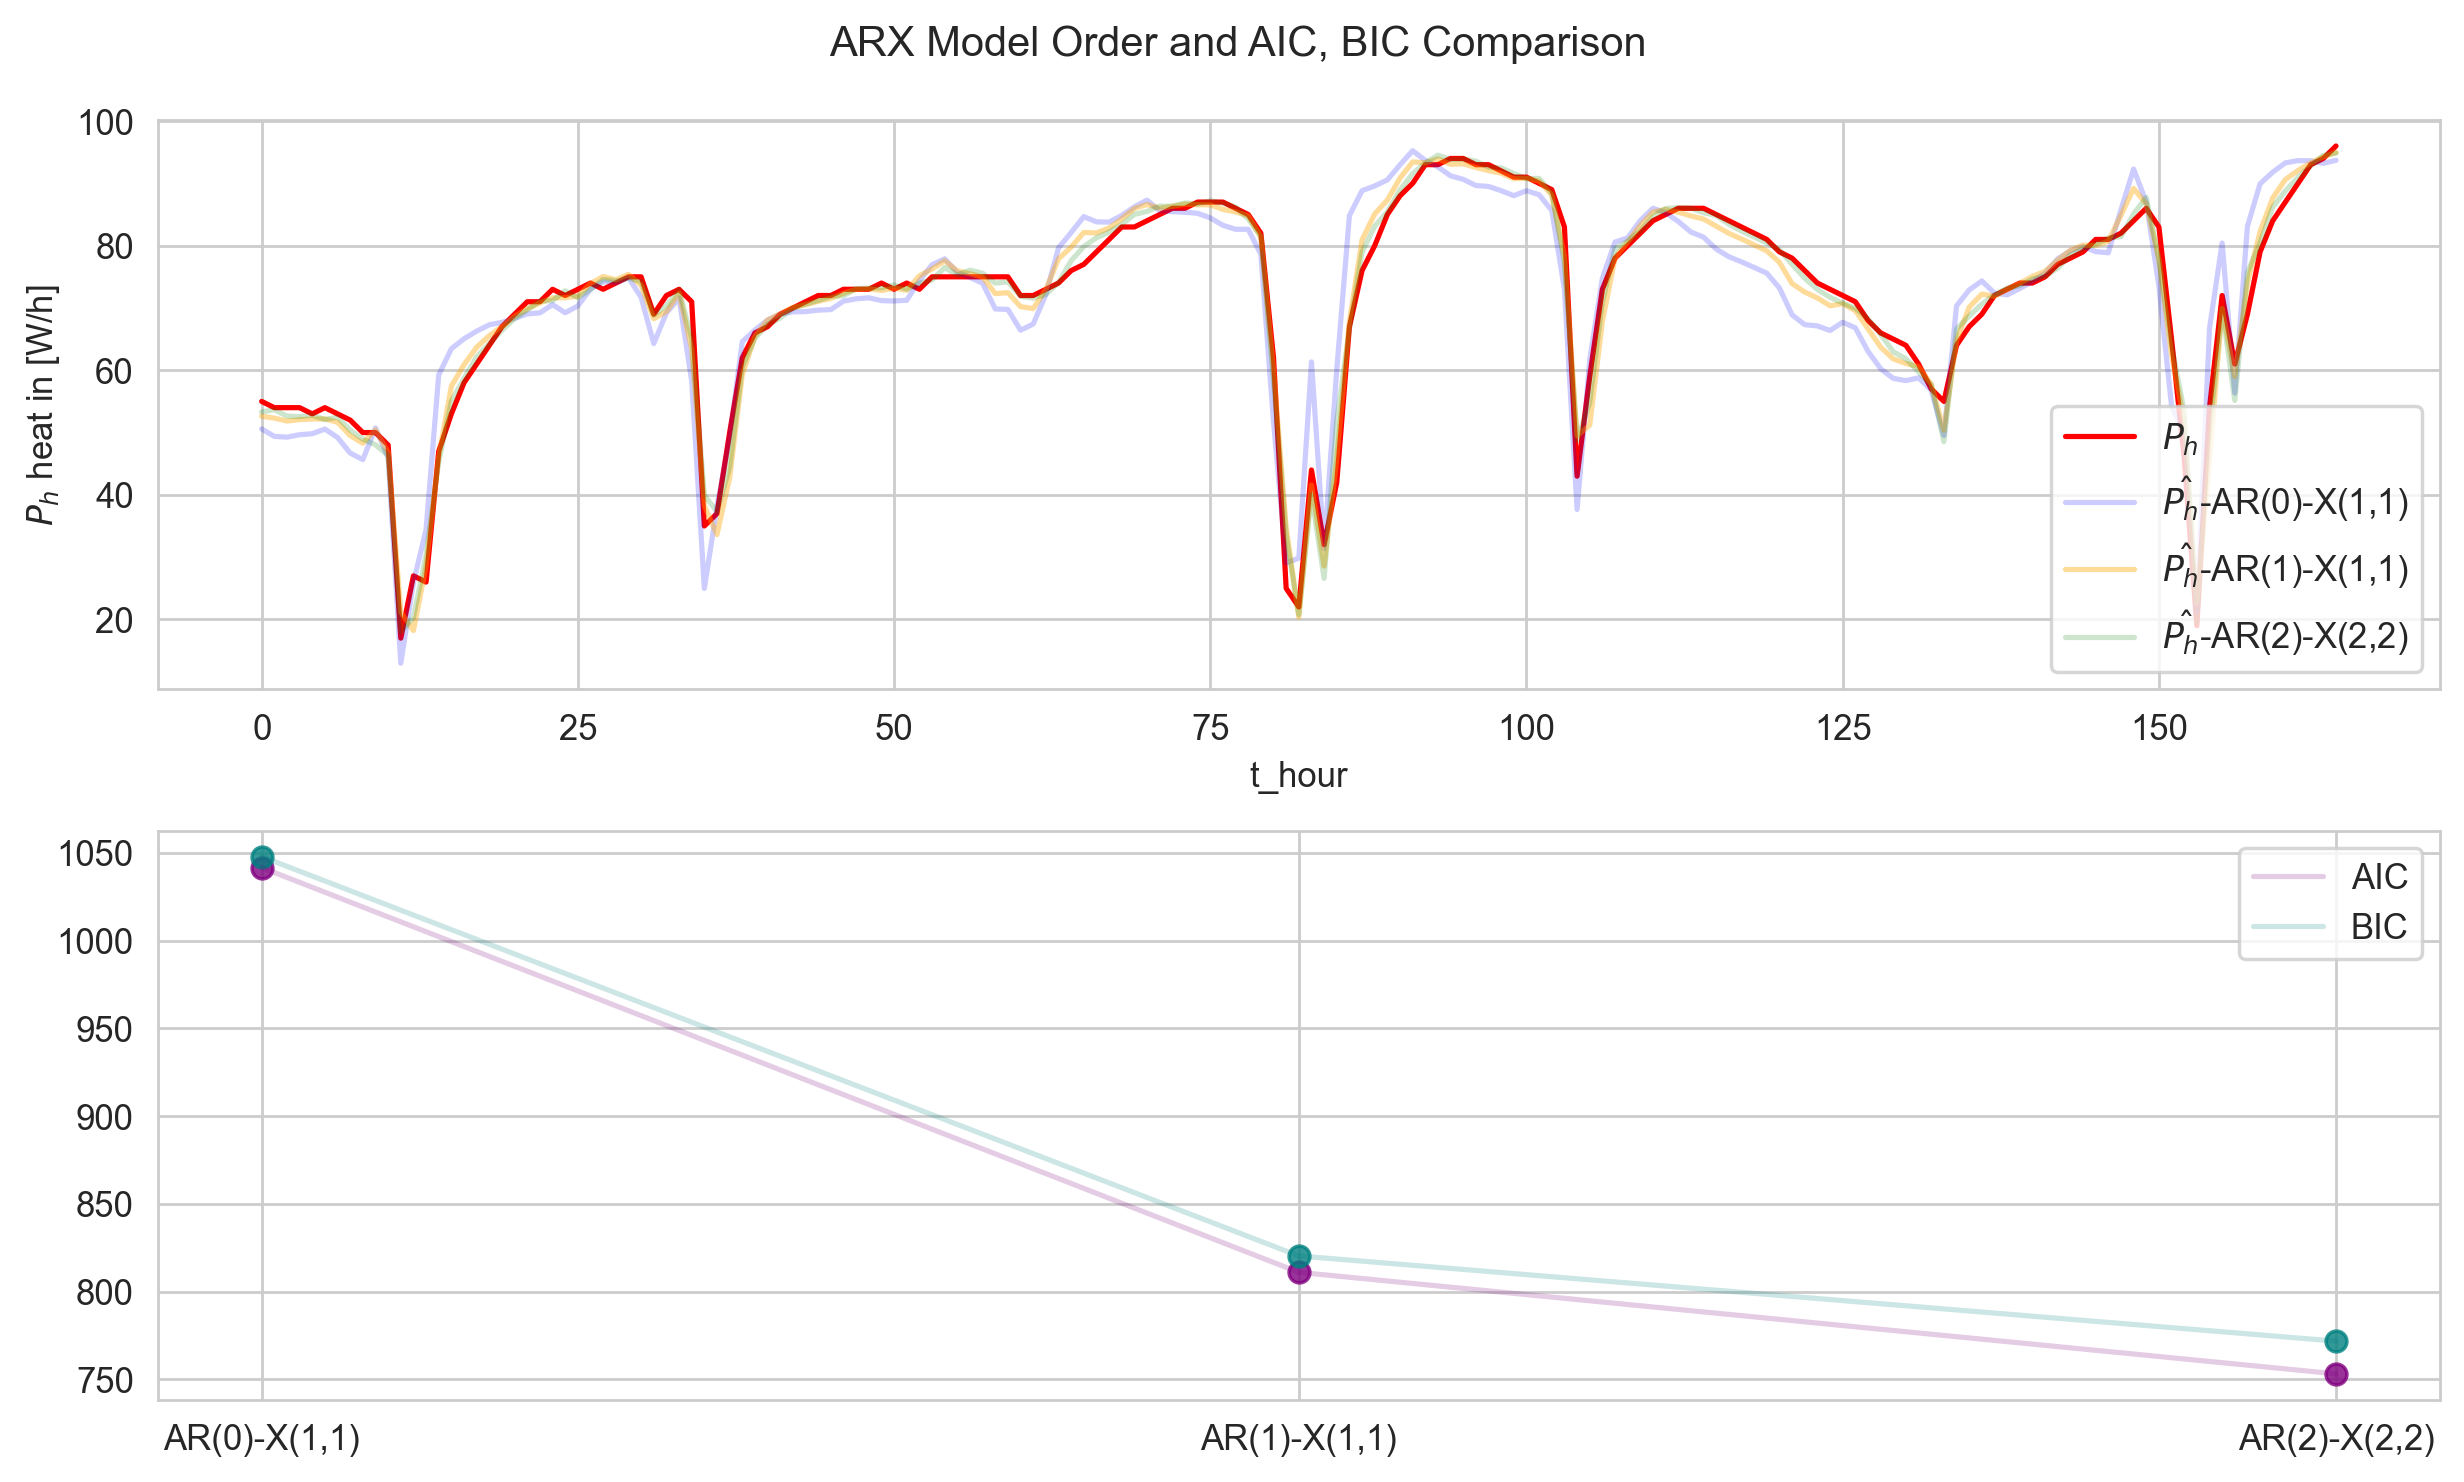

In [963]:
# compare AIC, BIC for AR(0)-X(1,1) vs. AR(1)-X(1,1) vs. AR(2)-X(2,2)
scores = {'aic':[], 'bic':[], 'hqic':[]}
highest_order = 2
fig, axs = plt.subplots(2,1, dpi=250, figsize=(10,6))
fig.suptitle("ARX Model Order and AIC, BIC Comparison")

# AR(0)-X(1,1) without constant - Ex 3.5
p, order = 2, 0
y = df_train.Ph.to_numpy().reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:, 0] = df_train.Tdelta.to_numpy()
X[:, 1] = df_train.Gv.to_numpy()
omega = np.linalg.inv(X.T@X)@X.T@y
aic, bic, hqic = aic_bic_hqic(X, y, omega)
scores['aic'].extend(aic)
scores['bic'].extend(bic)
scores['hqic'].extend(hqic)
axs[0].plot(y[highest_order-order:], label="$P_h$", c='r')
axs[0].plot((X@omega)[highest_order-order:], label="$\hat{P_h}$-AR(0)-X(1,1)", c='blue', alpha=0.2)

# AR(1)-X(1,1) - Ex 3.6
p, order = 3, 1
y = df_train.Ph.to_numpy()[order:].reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:,0] = df_train.Ph.to_numpy()[:-order]
X[:,1] = df_train.Tdelta.to_numpy()[order:]
X[:,2] = df_train.Gv.to_numpy()[order:]
omega = np.linalg.inv(X.T@X)@X.T@y
aic, bic, hqic = aic_bic_hqic(X, y, omega)
scores['aic'].extend(aic)
scores['bic'].extend(bic)
scores['hqic'].extend(hqic)
axs[0].plot((X@omega)[highest_order-order:], label="$\hat{P_h}$-AR(1)-X(1,1)", c='orange', alpha=0.4)

# AR(2)-X(2,2) - Ex 3.7
p, order = 6, 2
y = df_train.Ph.to_numpy()[order:].reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:,0] = df_train.Ph.to_numpy()[1:-order+1]     # phi_1
X[:,1] = df_train.Ph.to_numpy()[:-order]        # phi_2
X[:,2] = df_train.Tdelta.to_numpy()[order:]     # omega_1
X[:,3] = df_train.Tdelta.to_numpy()[1:-order+1] # omega_2
X[:,4] = df_train.Gv.to_numpy()[order:]         # beta_1
X[:,5] = df_train.Gv.to_numpy()[1:-order+1]     # beta_2
omega = np.linalg.inv(X.T@X)@X.T@y
aic, bic, hqic = aic_bic_hqic(X, y, omega)
scores['aic'].extend(aic)
scores['bic'].extend(bic)
scores['hqic'].extend(hqic)
axs[0].plot((X@omega)[highest_order-order:], label="$\hat{P_h}$-AR(2)-X(2,2)", c='green', alpha=0.2)
axs[0].legend()
axs[0].set_xlabel("t_hour")
axs[0].set_ylabel("$P_h$ heat in [W/h]")

# AIC, BIC, HQIC plot
axs[1].plot(scores['aic'], label="AIC", c="purple", alpha=0.2)
axs[1].plot(scores['bic'], label="BIC", c="teal", alpha=0.2)
#axs[1].plot(scores['hqic'], label="HQIC", c="blue", alpha=0.2)

axs[1].scatter(np.arange(len(scores['aic'])), scores['aic'], c="purple", alpha=0.8)
axs[1].scatter(np.arange(len(scores['bic'])), scores['bic'], c="teal", alpha=0.8)
#axs[1].scatter(np.arange(len(scores['hqic'])), scores['hqic'], c="blue", alpha=0.2)
axs[1].legend()
axs[1].set_xticks(np.arange(len(scores['aic'])))
axs[1].set_xticklabels(['AR(0)-X(1,1)', 'AR(1)-X(1,1)', 'AR(2)-X(2,2)'])
plt.tight_layout()

*Model Selection Conclusion:*

This is a classic Elbow curve. In various modelling fields, information theoretical measures or straight residual measures (such as MSE, etc.) are plotted against different model variations. The general idea is, to deduce at which point, there is a good trade-off between parameters of the model and the model performance.
In this case, we have the x-axis as increasing model order, hence increasing complexity and proneness to overfitting. Hence, we are looking for a trade-off between performance and model complexity. It is an interesting choice of metric to do this kind of plot. AIC and BIC inherently punish model complexity, as long as $\log n > 2$, the BIC does even more so; this also explains the slight difference between those two curves. Thus they theoretically already account for one of the decision parameter that such Elbow-curve is intended to help with.
If we look at the plot, there is a clear trend towards the more complex AR(2)-X(2,2) model. Traditionally, the decision here would be to select the AR(1)-X(1,1) model, as it already performs relatively well and the performance gain to the more complex model is very small. Hence, favour simplicity before performance, in the hope of better generalisation.

However, as the AIC and BIC both already punish the increased model complexity of AR(2)-X(2,2) model, but still produce a lower score, the interpretation would yield in: "more complex, but worth it". Therefore, the model selection would fall onto the AR(2)-X(2,2) model.

UPDATE WITH CONCLUSIONS FROM BOX-LJUNG TEST

##### 3.8 OneStep Predictions and RMSE

- for each model AR(0)-X(1,1), AR(1)-X(1,1), AR(2)-X(2,2) make one-step predictions through the TEST period
    - for design matrix X: take at least $k$ observations of the train dataset (with $k$ as lag equivalent to $p$ as the AR-order)
    - to already have the burn-in before the actual test-dataset
    - hence, the burn in only takes out samples from the train-dataset
- find suitable $k$ by testing out how much burn-in $b$ needed
    - fit on only the test-data until no more negativale values for P_h
- then calculate the residuals and RMSE for each model

CORRECTION:
- after finding that 1-step predictions are just X@omega, there is no burn-in! ONLY for RLS models, which this is not!

In [936]:
cutoff = "2013-02-06 00:00"
df_test = df[df.tdate>cutoff]

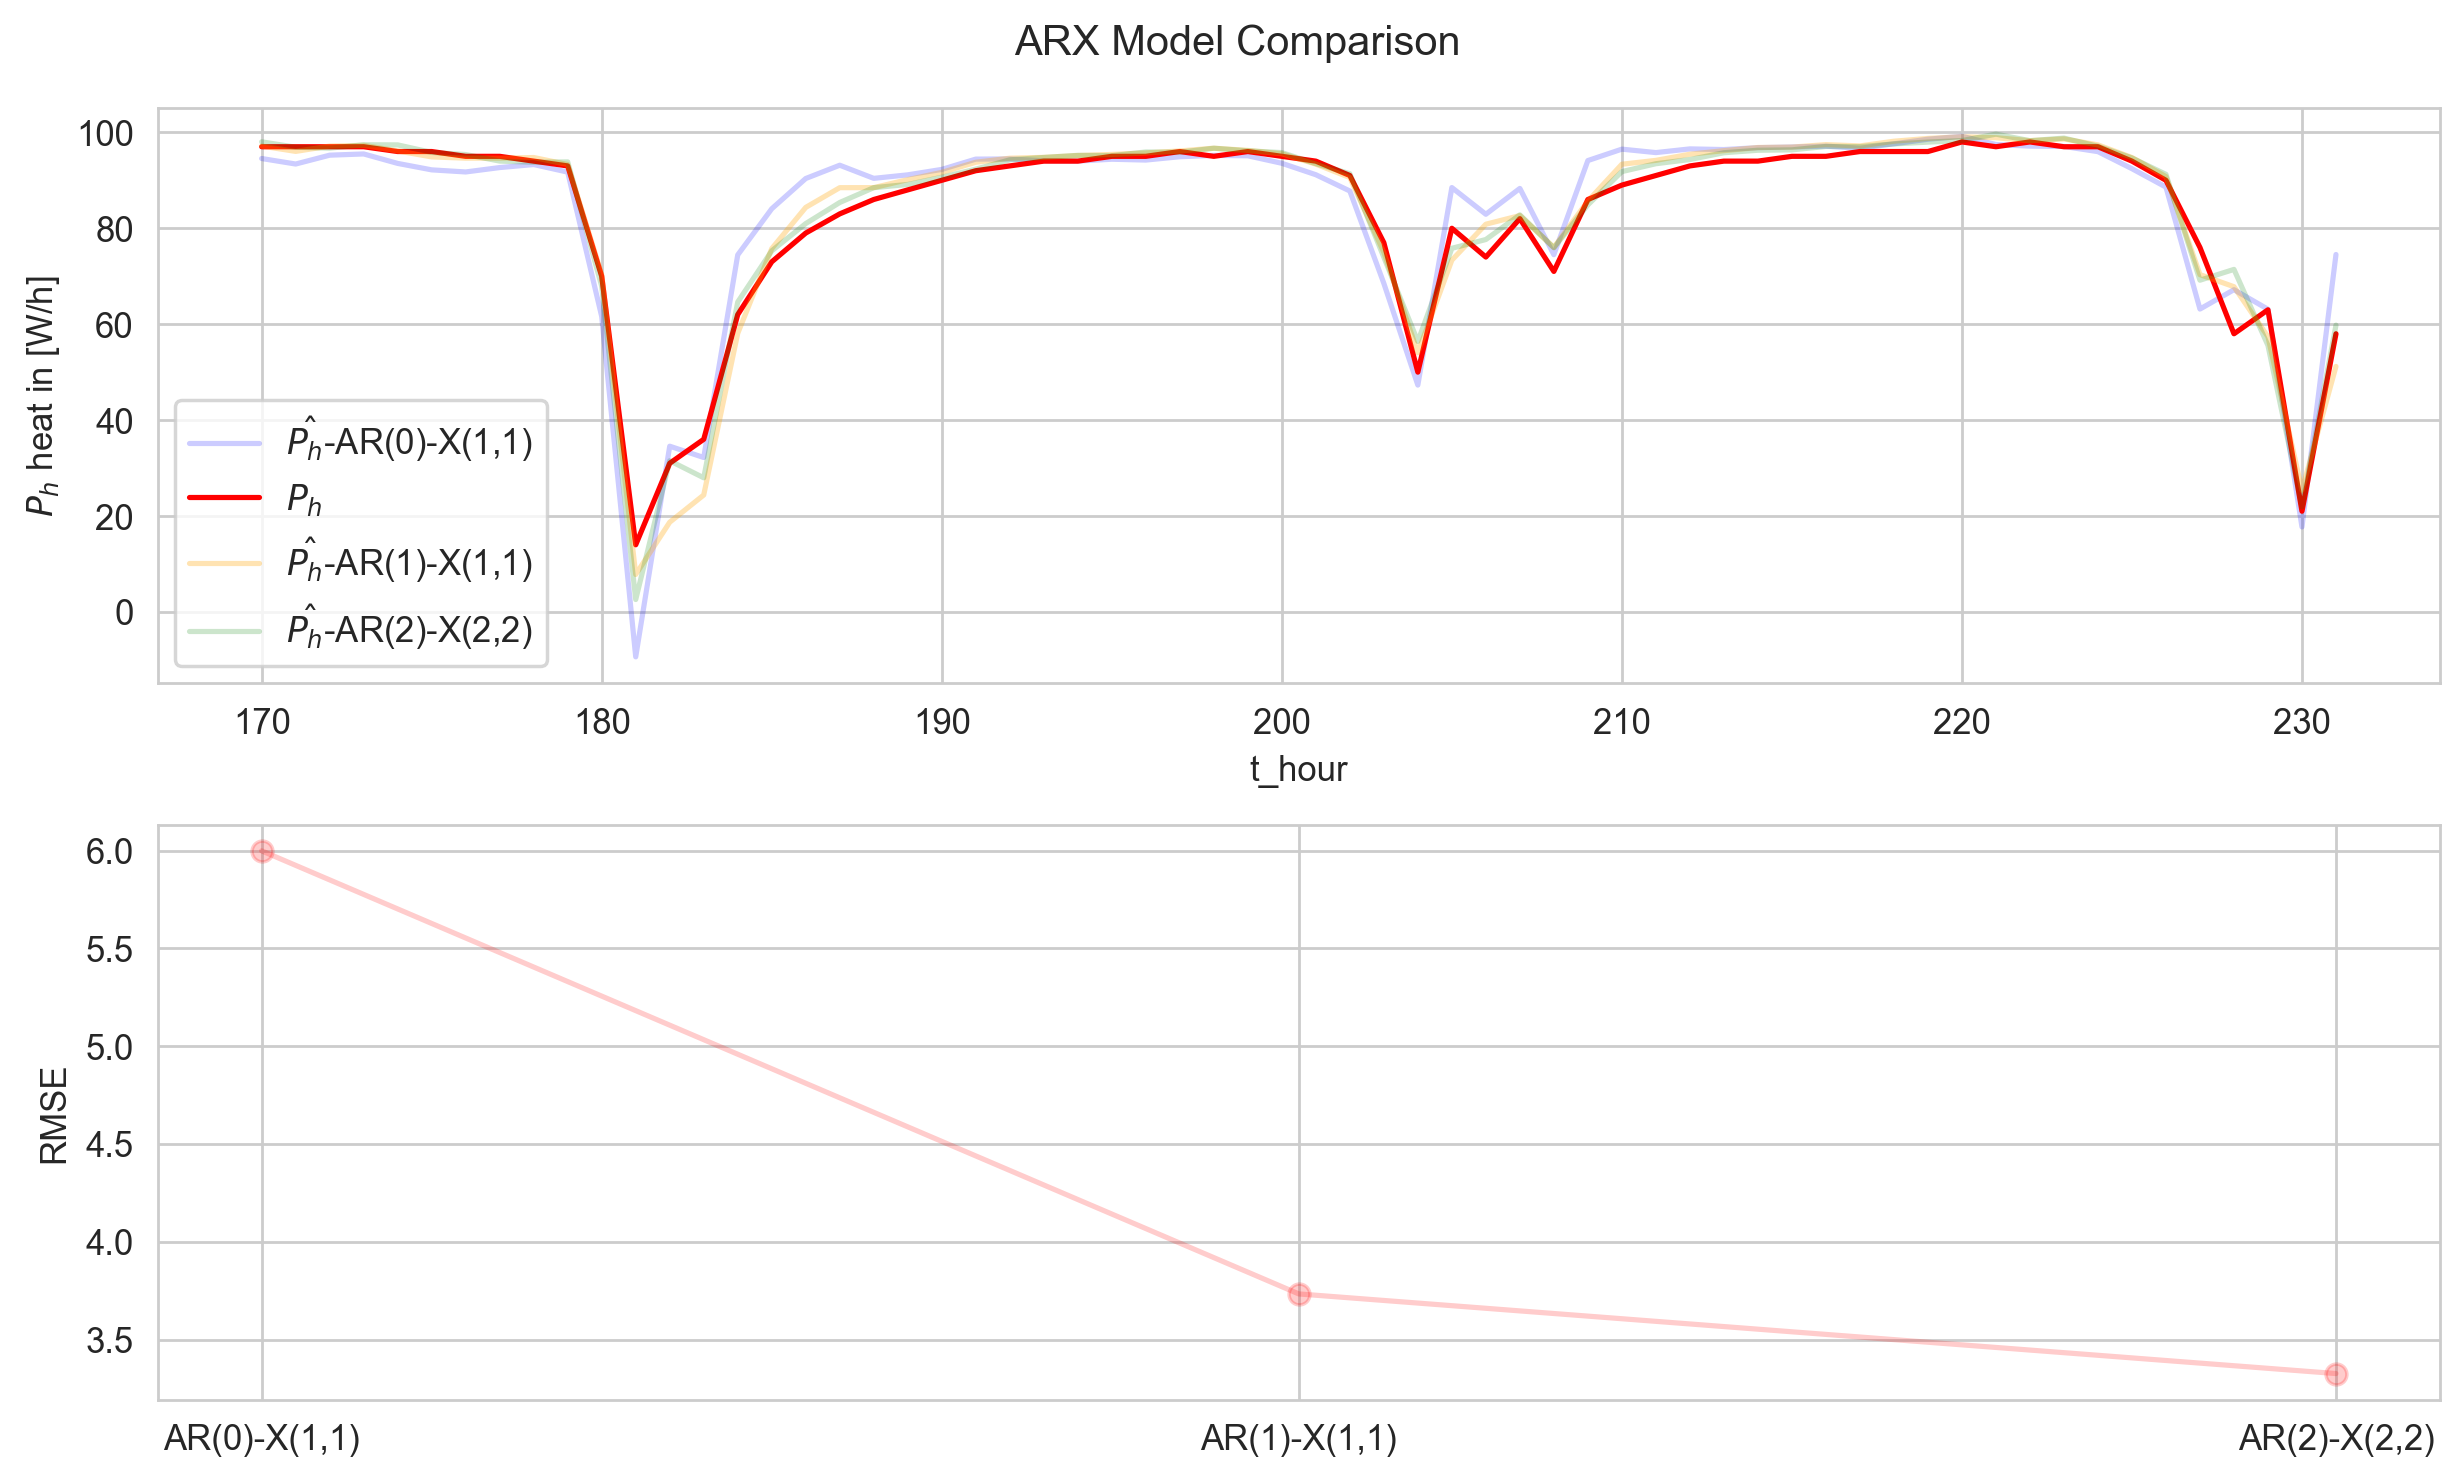

In [1001]:
# compare RMSE for AR(0)-X(1,1)     vs.     AR(1)-X(1,1) vs.    AR(2)-X(2,2)
rmse = {'AR(0)-X(1,1)':0, 'AR(1)-X(1,1)':0, 'AR(2)-X(2,2)':0}
highest_order, b = 2, 0                    # b = burn-in
fig, axs = plt.subplots(2,1, dpi=250, figsize=(10,6))
fig.suptitle("ARX Model Comparison")

# AR(0)-X(1,1) without constant - Ex 3.5
p, order = 2, 0
y = df_train.Ph.to_numpy().reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:, 0] = df_train.Tdelta.to_numpy()
X[:, 1] = df_train.Gv.to_numpy()
y_test = df_test.Ph.to_numpy().reshape(-1,1)
X_test = np.zeros((y_test.shape[0], p))
X_test[:, 0] = df_test.Tdelta.to_numpy()
X_test[:, 1] = df_test.Gv.to_numpy()
omega = np.linalg.inv(X.T@X)@X.T@y
os_pred = X_test@omega
rmse['AR(0)-X(1,1)'] = np.sqrt(np.mean((y_test[b:]-os_pred[b:])**2))
axs[0].plot(df_test.thour[highest_order+b:], os_pred[highest_order-order+b:], label="$\hat{P_h}$-AR(0)-X(1,1)", c='blue', alpha=0.2)
axs[0].plot(df_test.thour[highest_order+b:], y_test[highest_order+b:], label="$P_h$", c='r')

# AR(1)-X(1,1) - Ex 3.6
p, order = 3, 1
y = df_train.Ph.to_numpy()[order:].reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:,0] = df_train.Ph.to_numpy()[:-order]
X[:,1] = df_train.Tdelta.to_numpy()[order:]
X[:,2] = df_train.Gv.to_numpy()[order:]
y_test = df_test.Ph.to_numpy()[order:].reshape(-1,1)
X_test = np.zeros((y_test.shape[0], p))
X_test[:,0] = df_test.Ph.to_numpy()[:-order]
X_test[:,1] = df_test.Tdelta.to_numpy()[order:]
X_test[:,2] = df_test.Gv.to_numpy()[order:]
omega = np.linalg.inv(X.T@X)@X.T@y
os_pred = X_test@omega
rmse['AR(1)-X(1,1)'] = np.sqrt(np.mean((y_test[b:]-os_pred[b:])**2))
axs[0].plot(df_test.thour[highest_order+b:], os_pred[highest_order-order+b:], label="$\hat{P_h}$-AR(1)-X(1,1)", c='orange', alpha=0.3)

# AR(2)-X(2,2) - Ex 3.7
p, order = 6, 2
y = df_train.Ph.to_numpy()[order:].reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:,0] = df_train.Ph.to_numpy()[1:-order+1]     # phi_1
X[:,1] = df_train.Ph.to_numpy()[:-order]        # phi_2
X[:,2] = df_train.Tdelta.to_numpy()[order:]     # omega_1
X[:,3] = df_train.Tdelta.to_numpy()[1:-order+1] # omega_2
X[:,4] = df_train.Gv.to_numpy()[order:]         # beta_1
X[:,5] = df_train.Gv.to_numpy()[1:-order+1]     # beta_2

y_test = df_test.Ph.to_numpy()[order:].reshape(-1,1)
X_test = np.zeros((y_test.shape[0], p))
X_test[:,0] = df_test.Ph.to_numpy()[1:-order+1]     # phi_1
X_test[:,1] = df_test.Ph.to_numpy()[:-order]        # phi_2
X_test[:,2] = df_test.Tdelta.to_numpy()[order:]     # omega_1
X_test[:,3] = df_test.Tdelta.to_numpy()[1:-order+1] # omega_2
X_test[:,4] = df_test.Gv.to_numpy()[order:]         # beta_1
X_test[:,5] = df_test.Gv.to_numpy()[1:-order+1]     # beta_2
omega = np.linalg.inv(X.T@X)@X.T@y
os_pred = X_test@omega
rmse['AR(2)-X(2,2)'] = np.sqrt(np.mean((y_test[b:]-os_pred[b:])**2))
axs[0].plot(df_test.thour[highest_order+b:], os_pred[b:], label="$\hat{P_h}$-AR(2)-X(2,2)", c='green', alpha=0.2)
axs[0].legend()
axs[0].set_xlabel("t_hour")
axs[0].set_ylabel("$P_h$ heat in [W/h]")

# AIC, BIC plot
axs[1].plot([round(v,4) for k,v in rmse.items()], c="red", alpha=0.2)
axs[1].scatter(np.arange(len(rmse.keys())), [round(v,4) for k,v in rmse.items()], c="red", alpha=0.2)
axs[1].set_xticks(np.arange(len(rmse.keys())))
axs[1].set_xticklabels(['AR(0)-X(1,1)', 'AR(1)-X(1,1)', 'AR(2)-X(2,2)'])
axs[1].set_ylabel("RMSE")
plt.tight_layout()

*Conclusion:*

Does this yield the same model selection as via the AIC, BIC metrics / criteria?

Yes and no. Only going via the RMSE, we could conclude from the first approach, where we only used pure test-dataset samples, that we should select the AR(2)-X(2,2) model.
However, after adjusting the setting (to have a spill of samples from the train-dataset) for a technically more fair comparison, the RMSE would yield the conclusion to select the AR(1)-X(1,1).

To put this into perspective, the RMSE is overall much lower with the second modelling approach. This makes sense makes sense, since there is much more information available to the model. This lets us conclude that there is a lot of relevant information in the further past. 
Yet, there seems to be a notion that a model with shorter lag, an AR(1) component, captures this short-term behaviour better than a longer lag. This could be interpreted as that past information is overall valuable, but the series behaviour is ultimately very short-term oriented.

UPDATE CONCLUSION
- after adjusting to predict on test dataset from omega fitted on traininf data

##### 3.9 k-step predictions

In [978]:
def ar_k_step_prediction(series, phi_hat, p, start_index, k):
    forecast = list(series[start_index - p:start_index][::-1])
    for _ in range(k):
        pred = np.dot(phi_hat, forecast[:p])
        forecast.insert(0, pred)  # shift forward
    return forecast[:k][::-1]  # return in order t+1, t+2, ..., t+k

def build_ar_design_matrix(series, p):
    n = len(series)
    X = np.zeros((n - p, p))
    y = series[p:]
    for i in range(p, n):
        X[i - p] = series[i - p:i][::-1]  # lagged values, reversed
    return X, y

def get_ARX_KStepPredictions(X:np.ndarray, y:np.ndarray, omega:np.ndarray, k:int, ar_order:int):
    y_init = y[:ar_order]
    n = X.shape[0]
    X_exo = X[:, ar_order:]
    predictions = []
    for t in range(n):
        future = y_init.copy().tolist()
        for step in range(k):
            idx = t+step
            t_exo = X_exo[idx]
            t_ar = np.zeros((1, ar_order))
            for i in range(ar_order):
                t_ar[:, i] = future[-(i+1)]
            Xt = np.concatenate([t_exo, t_ar], axis=1)
            future.append(Xt@omega)
        if len(future) > len(y_init):
            predictions.append(future[-1])
        else:
            predictions.append(np.nan)
    return predictions


def arx_k_step_predict_ar2_x1_1(X, y_init, phi, beta, k):
    """
    Perform k-step-ahead recursive predictions for an ARX(2) model with 2 exogenous inputs.

    Parameters:
    - X: np.ndarray of shape (n, 2) or (n, 2 + k - 1)
        Each row: [u_t^{(1)}, u_t^{(2)}] (exogenous inputs at time t)
    - y_init: list or np.array
        Initial time series values: must have at least 2 values for AR(2)
    - phi: array-like of length 2
        AR coefficients [phi1, phi2]
    - beta: array-like of length 2
        Coefficients for exogenous inputs
    - k: int
        Number of steps ahead to predict

    Returns:
    - y_preds: np.ndarray of shape (n,)
        k-step-ahead predicted values for each time t
    """
    n = X.shape[0]
    y_preds = []

    # Initialize internal time series with history
    y_series = list(y_init)

    for t in range(n):
        # For k-step ahead prediction from time t:
        y_future = y_series.copy()

        for step in range(k):
            idx = t + step  # where to pull exogenous inputs
            if idx >= n:
                break  # Out of bounds, stop prediction

            # Use past values (from y_future)
            y_lag1 = y_future[-1]
            y_lag2 = y_future[-2]

            # Exogenous inputs for this step
            u = X[idx]

            # Linear ARX model prediction
            y_hat = phi[0] * y_lag1 + phi[1] * y_lag2 + beta[0] * u[0] + beta[1] * u[1]
            y_future.append(y_hat)

        # Append final prediction after k steps
        if len(y_future) > len(y_series):
            y_preds.append(y_future[-1])
        else:
            y_preds.append(np.nan)  # not enough data to predict

    return np.array(y_preds)

def arx_k_step_predict_ar2_x2_2(X, y_init, phi, beta, k):
    """
    Perform k-step-ahead recursive predictions for an ARX(2) model with 2 exogenous inputs.

    Parameters:
    - X: np.ndarray of shape (n, 2) or (n, 2 + k - 1)
        Each row: [u_t^{(1)}, u_t^{(2)}] (exogenous inputs at time t)
    - y_init: list or np.array
        Initial time series values: must have at least 2 values for AR(2)
    - phi: array-like of length 2
        AR coefficients [phi1, phi2]
    - beta: array-like of length 2
        Coefficients for exogenous inputs
    - k: int
        Number of steps ahead to predict

    Returns:
    - y_preds: np.ndarray of shape (n,)
        k-step-ahead predicted values for each time t
    """
    n = X.shape[0]
    y_preds = []

    # Initialize internal time series with history
    y_series = list(y_init)

    for t in range(n):
        # For k-step ahead prediction from time t:
        y_future = y_series.copy()

        for step in range(k):
            idx = t + step  # where to pull exogenous inputs
            if idx >= n:
                break  # Out of bounds, stop prediction

            # Use past values (from y_future)
            y_lag1 = y_future[-1]
            y_lag2 = y_future[-2]

            # Exogenous inputs for this step
            u = X[idx]

            # Linear ARX model prediction
            y_hat = phi[0] * y_lag1 + phi[1] * y_lag2 + beta[0] * u[0] + beta[1] * u[1] + beta[2]*u[2] + beta[3]*u[3]
            y_future.append(y_hat)

        # Append final prediction after k steps
        if len(y_future) > len(y_series):
            y_preds.append(y_future[-1])
        else:
            y_preds.append(np.nan)  # not enough data to predict

    return np.array(y_preds)


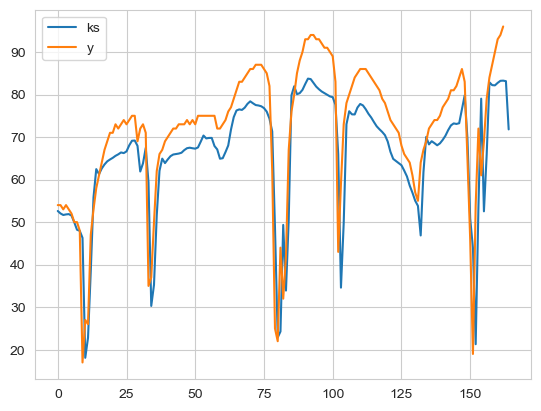

In [1008]:
k = 2
ks_pred = arx_k_step_predict_ar2_x2_2(X[:, 2:], df.Ph.to_numpy()[:2], omega[:2], omega[2:], k=k)
plt.plot(ks_pred, label='ks')
plt.plot(y[k:], label='y')
plt.legend()

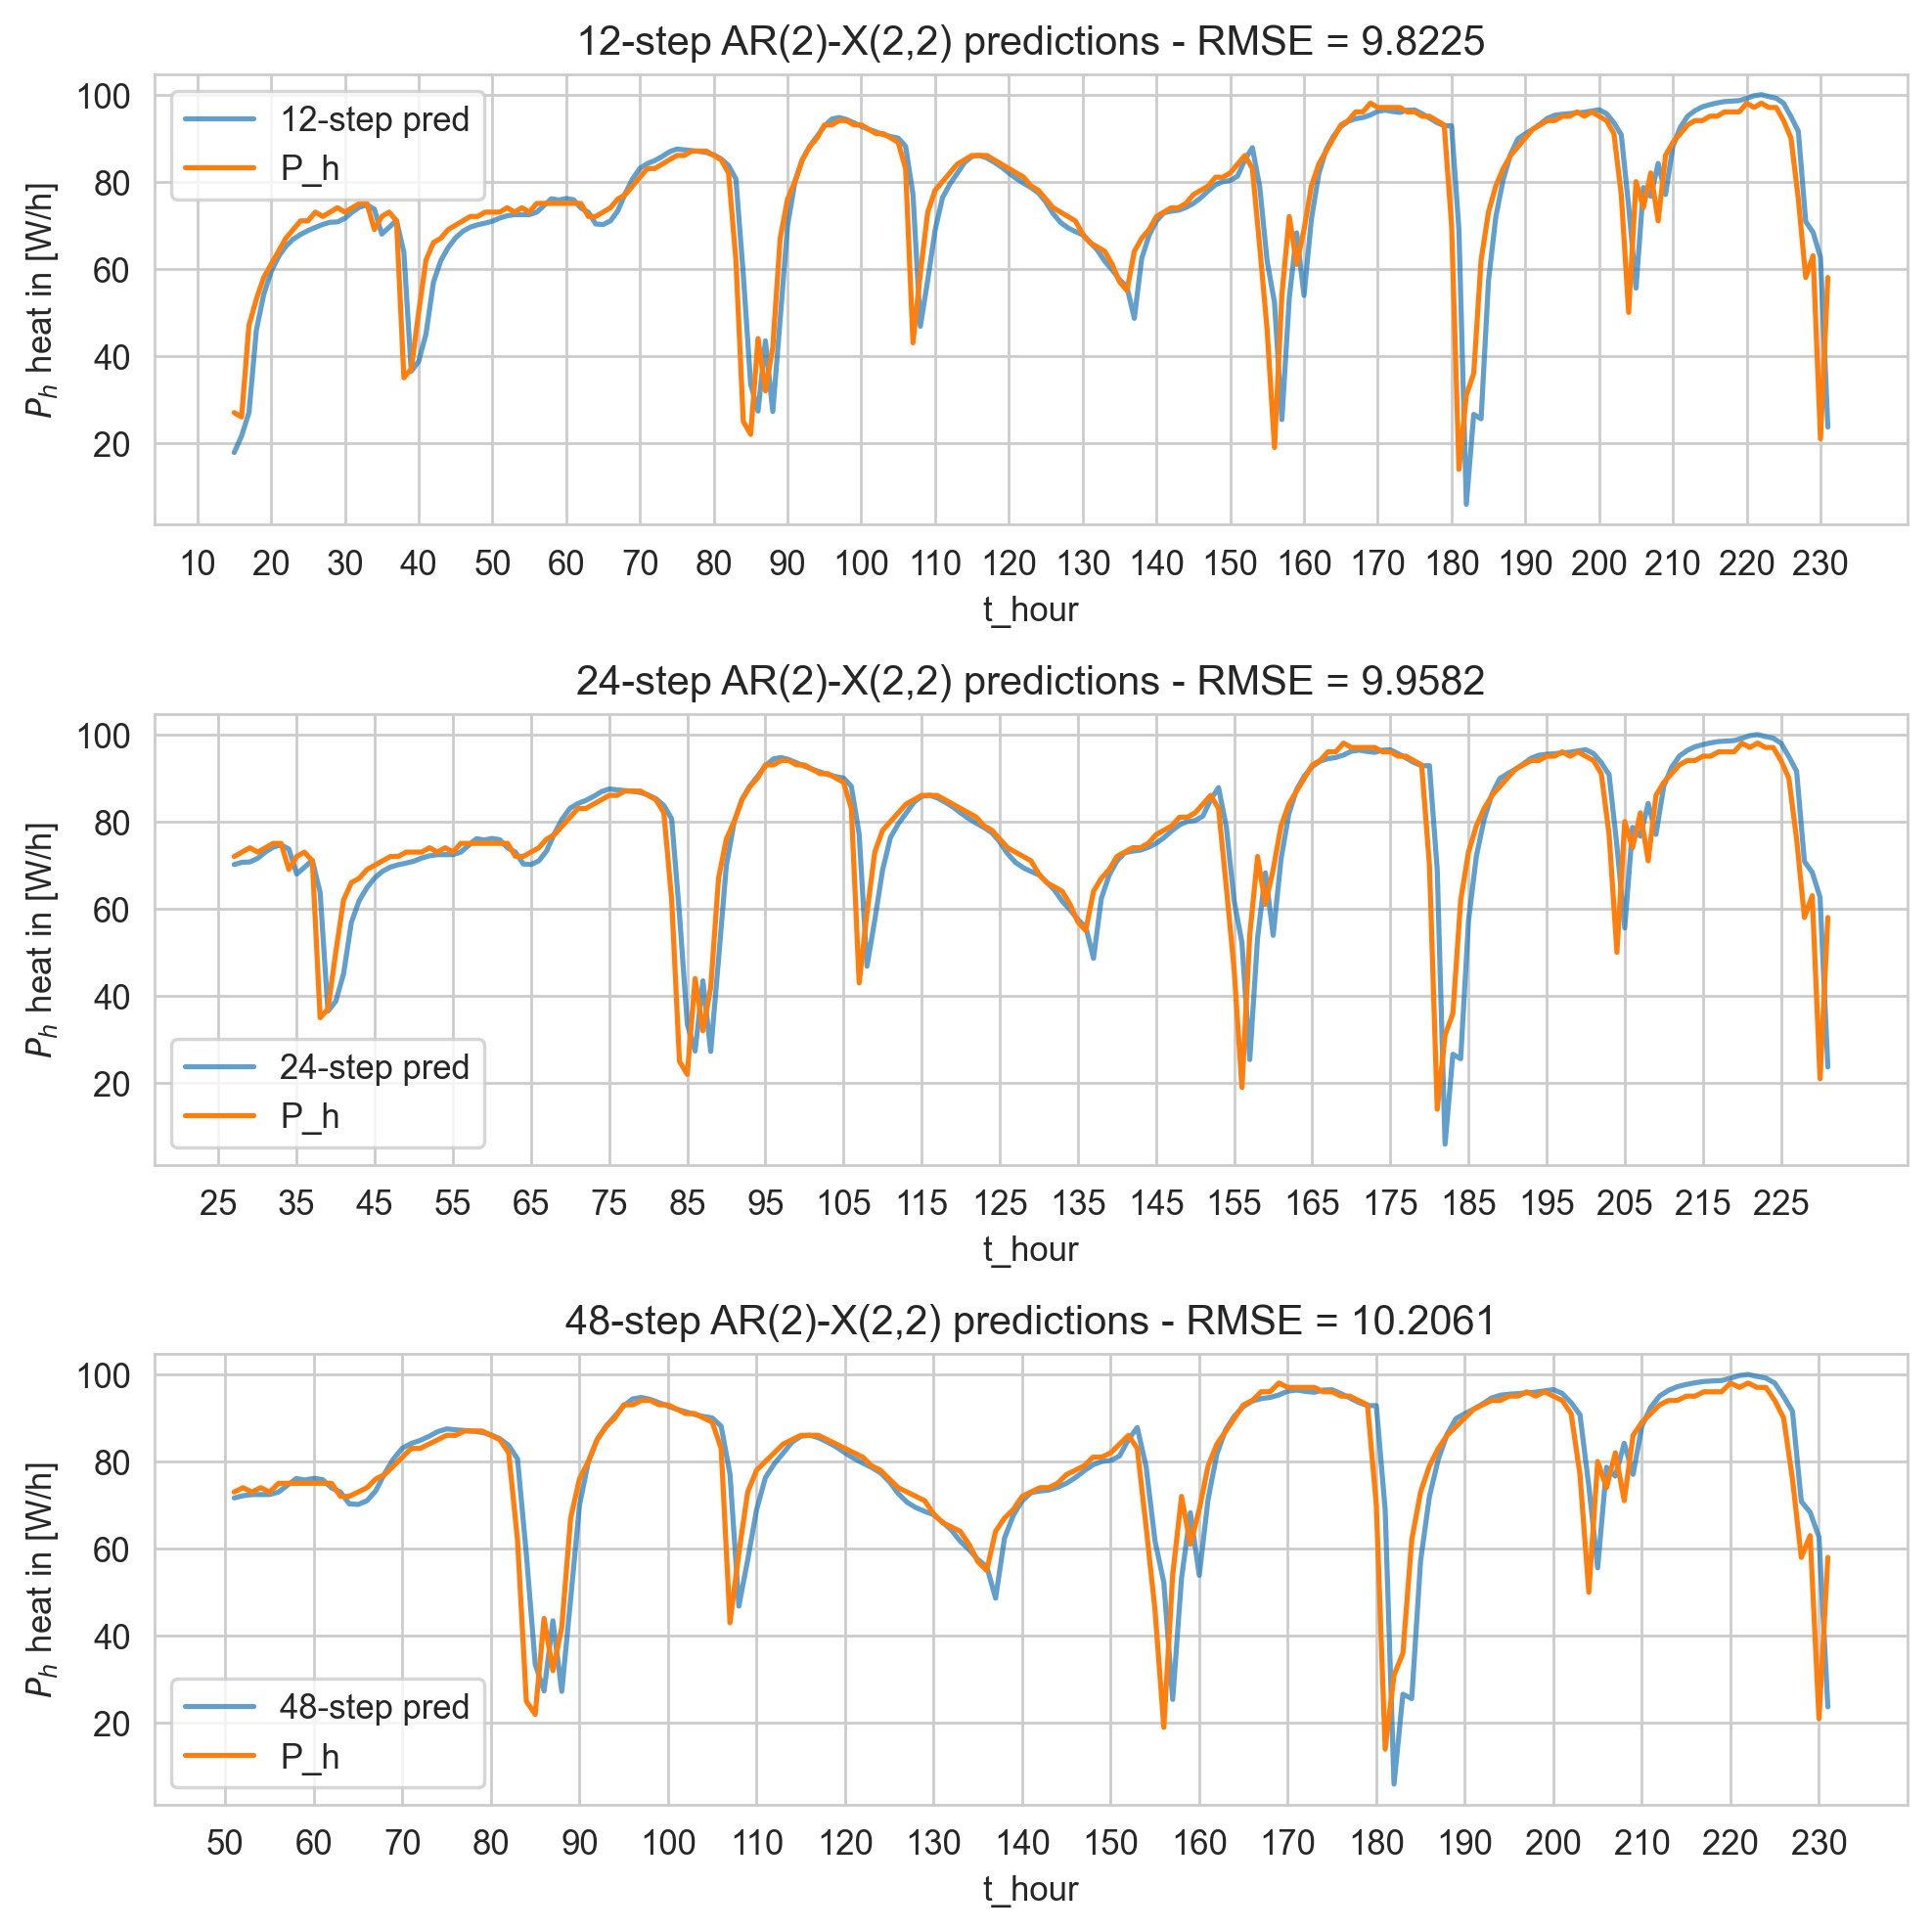

In [998]:
import warnings
warnings.filterwarnings('ignore')

# select the AR(2)-X(2,2) for df_train + df_test
p, order = 6, 2
y = df.Ph.to_numpy()[order:].reshape(-1,1)
X = np.zeros((y.shape[0], p))
X[:,0] = df.Ph.to_numpy()[1:-order+1]     # phi_1
X[:,1] = df.Ph.to_numpy()[:-order]        # phi_2
X[:,2] = df.Tdelta.to_numpy()[order:]     # omega_1
X[:,3] = df.Tdelta.to_numpy()[1:-order+1] # omega_2
X[:,4] = df.Gv.to_numpy()[order:]         # beta_1
X[:,5] = df.Gv.to_numpy()[1:-order+1]     # beta_2
omega = np.linalg.inv(X.T@X)@X.T@y

fig, axs = plt.subplots(3,1, figsize=(8,8), dpi=250)
#fig.subplots_adjust(hspace=0.8)
for i, k in enumerate([12, 24, 48]):
    ks_pred = arx_k_step_predict_ar2_x2_2(X[:, 2:], df.Ph.to_numpy()[:2], omega[:2], omega[2:], k=k)
    axs[i].set_title(f"{k}-step AR(2)-X(2,2) predictions - RMSE = {np.sqrt(np.mean((y[k:]-ks_pred[:-k])**2)):.4f}")
    axs[i].plot(df.thour[k+order:], ks_pred[:-k], label=f'{k}-step pred', alpha=0.7)
    #axs[i].plot(np.arange(k+order, len(df)+k), ks_pred, label=f'{k}-step pred', alpha=0.7)
    axs[i].plot(df.thour[k+order:], y[k:], label='P_h')
    #axs[i].set_xticklabels(df.index[b+k+order:].date, rotation=25, fontsize=7)
    axs[i].set_xticks(np.arange((b+k+order)-((b+k+order)%5), len(df), 10))
    axs[i].set_xlabel("t_hour")
    axs[i].set_ylabel('$P_h$ heat in [W/h]')
    axs[i].legend()
plt.tight_layout()


Text(0, 0.5, 'RMSE')

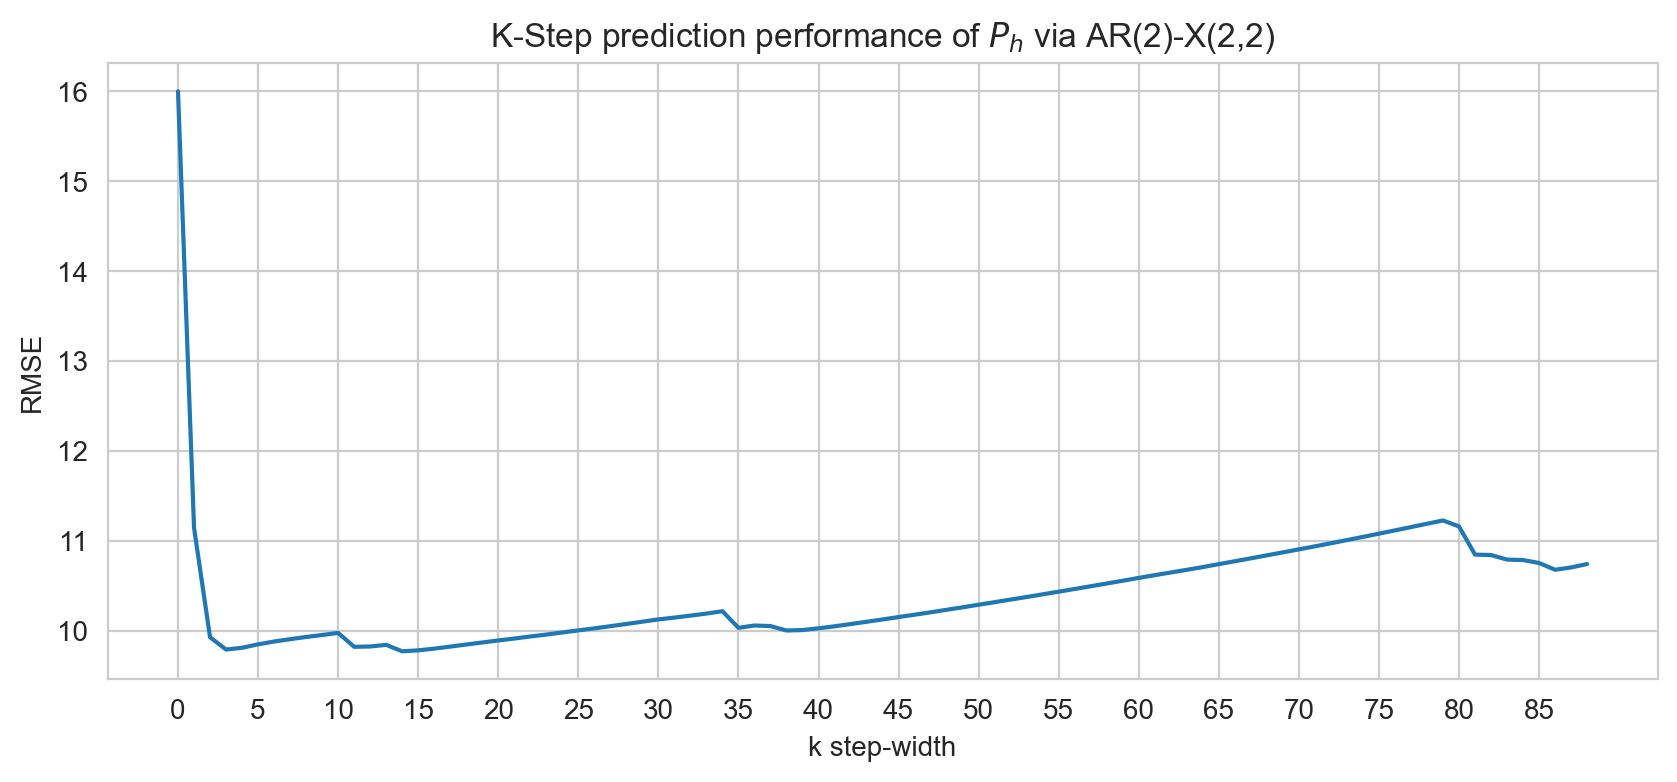

In [1000]:
# plot k step-width against RMSE
# k_rmse, b = [], 6       # burn-in=b=6 for k<8 too low

plt.figure(figsize=(10,4), dpi=200)
plt.title("K-Step prediction performance of $P_h$ via AR(2)-X(2,2)")
k_rmse = []
for k in range(1,90):
    ks_pred = arx_k_step_predict_ar2_x2_2(X[:, 2:], df.Ph.to_numpy()[:2], omega[:2], omega[2:], k=k)
    k_rmse.append(float(np.sqrt(np.mean((y[k:]-ks_pred[:-k])**2))))
plt.plot(k_rmse)

plt.xlabel("k step-width")
plt.xticks(np.arange(0,90,5))
plt.ylabel("RMSE")

- the RMSE heavily depends on the selected burn-in allowance; from b≥9 the RMSE stays mostly below 5
- the RMSE shows a seasonality on the step-width; how to explain?
    - $P_h$ clearly shows some seasonal drops
    - there are a few exceptions to these drops:
        - between 2013-02-01 and 2013-02-02
        - between 2013-02-04 and 2013-02-05
        - between 2013-02-07 and 2013-02-08
    - the drops are not as sharp
    - probably the model parameters, when fitted, encode an expectation of seasonality at these exception points as well
    - as this doesn't happen the model predicts wrong, thus the error peaks
    - a 2nd explanation would be the weakness of the predictions around the double (inverse) peaks
        - between 2013-02-02 and 2013-02-03
        - between 2013-02-06 and 2013-02-07

We selected the AR(2)-X(2,2) model, mainly because of the AIC, BIC selection criteria. From experience, they produce a very reliable selection process. 

Overall, the model performs well, the deviations are small, however, the residuals do not look like white noise yet. There is still a visible auto-regressive behaviour present. This could mean, that the model order or structure is not yet sufficient, a more complex model could resolve that.
Usually, the last option is to increase model complexity, but another argument for that is: The distribution of residuals is patterned. The model systematically overshoots for values of $P_h$ in the 'buckle' right after the steep drop of values in FIGURE and systematically undershoots values for the bottom of the drops.

Apart from the prediction accuracy (which could potentially be improved), in an operational setting the model would work just fine with multi-step predictions. It is not computationally expensive and would be easily integrated into a prediction pipeline.
Naturally, the further into the future we predict, the higher the uncertainty; that notion is present without calculating the prediction intervals. Beyond that, we saw certain points of the series (towards the drops of $P_h$) where the predictions tend to deviate; FIGURE, the seasonality of the RMSE over $k$ step-width. 
This does not improve if we simply choose a $k$ step-width, that produces a good RMSE, since we would work on a continually re-fitting real-time prediction pipeline. Hence, by the nature of the series, this point of drop in $P_h$ will naturally come, regardless of the k-step.

Modelling-wise an RLS model with higher "forgetting" coefficient may be a viable option, to account for these know effects.

Given that knowledge on the historic data, it would be wiser to simply accept an increased uncertainty in specific periods of the series and contextualize consequences: Reduce heating at the drops, but also have power available in case of slight mis-predictions.

It could also be an option to reduce the measurement interval from hourly to 5-min intervals, to be able to react quicker and counter prediction uncertainty.

##### 3.10 compare models for k-step predictions & summary

*Reflection on the model selection (3.6-3.8):*

The construction of the selection process via the exercise objectives, makes the selection process not a fair, comparable process, for a number of reasons:

1. The AIC, BIC are calculated on the training dataset, while the RMSE (without our adjustment) is calculated on the test dataset. This would make for a good approach, if the same metric was used, to verify how well the model behaves on different time-slices, basically how well the model generalises. Yet, this is not the case!
2. two different prediction approaces are used (full OLS fit and step-wise)
3. The burn-in for one-step or multi-step predictions is not considered.
4. Too few options for models are considered, the residuals still show auto-regressive behaviour.

We are comparing 2 different metrics (AIC, BIC together as information criteria) on 2 different time slices with 2 different prediction methods. If anything, it is not surprising to get different conclusions.
Given the drawbacks, this is not a very solid model selection process, comparing apples with pears.

Therefore, we go straight into a grid-search and test out all options:
- compare different ARX models